In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import cmocean.cm as cmo
from xmitgcm import open_mdsdataset


In [2]:
filename_state = 'diag_state'
filename_surf = 'diag_surf'

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_withhold/run_iter14/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
ds['Zl'] = ds.Zl.astype(float)

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0_noVelAssimIC/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter22/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds_vel = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_vel['XC'] = ds.XC.astype(float)
ds_vel['YC'] = ds.YC.astype(float)
ds_vel['Z'] = ds.Z.astype(float)
ds_vel['XG'] = ds.XG.astype(float)
ds_vel['YG'] = ds.YG.astype(float)
ds_vel['Zl'] = ds.Zl.astype(float)

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0_noVelAssimIC/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds_noTAO = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_noTAO['XC'] = ds.XC.astype(float)
ds_noTAO['YC'] = ds.YC.astype(float)
ds_noTAO['Z'] = ds.Z.astype(float)
ds_noTAO['XG'] = ds.XG.astype(float)
ds_noTAO['YG'] = ds.YG.astype(float)
ds_noTAO['Zl'] = ds.Zl.astype(float)

In [3]:
folder_name = '/home/edavenport/analysis/mitgcm-equatorial-waves/hovmoller/'

In [4]:
from scipy import signal
import xarray as xr

latMin = -0.1
latMax = 0.1
lon=220.0

target_theta = 20.0

theta = ds.THETA.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
theta_vel = ds_vel.THETA.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
theta_noTAO = ds_noTAO.THETA.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()


target_theta = 20.0
# Find where THETA crosses 20°C
Z20 = xr.apply_ufunc(
    np.interp,
    np.full_like(theta.isel(Z=0), target_theta),  # same shape (time, YC, XC)
    theta.isel(Z=slice(None, None, -1)),         # reverse in Z
    theta.Z[::-1],
    input_core_dims=[[], ['Z'], ['Z']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
)
Z20 = signal.detrend(Z20, axis=0)
Z20 = Z20 - Z20.mean()

# Build the DataArray with appropriate coordinates
Z20 = xr.DataArray(
    Z20,
    dims=('time', 'XC'),
    coords={'time': theta.time, 'XC': theta.XC},
    name='Z20 anomaly'
)

# Find where THETA crosses 20°C
Z20_vel = xr.apply_ufunc(
    np.interp,
    np.full_like(theta_vel.isel(Z=0), target_theta),  # same shape (time, YC, XC)
    theta_vel.isel(Z=slice(None, None, -1)),         # reverse in Z
    theta_vel.Z[::-1],
    input_core_dims=[[], ['Z'], ['Z']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
)

Z20_vel = signal.detrend(Z20_vel, axis=0)
Z20_vel = Z20_vel - Z20_vel.mean()

# Build the DataArray with appropriate coordinates
Z20_vel = xr.DataArray(
    Z20_vel,
    dims=('time', 'XC'),
    coords={'time': theta_vel.time, 'XC': theta_vel.XC},
    name='Z20'
)

# Find where THETA crosses 20°C
Z20_noTAO = xr.apply_ufunc(
    np.interp,
    np.full_like(theta_noTAO.isel(Z=0), target_theta),  # same shape (time, YC, XC)
    theta_noTAO.isel(Z=slice(None, None, -1)),         # reverse in Z
    theta_noTAO.Z[::-1],
    input_core_dims=[[], ['Z'], ['Z']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
)

Z20_noTAO = signal.detrend(Z20_noTAO, axis=0)
Z20_noTAO = Z20_noTAO - Z20_noTAO.mean()

# Build the DataArray with appropriate coordinates
Z20_noTAO = xr.DataArray(
    Z20_noTAO,
    dims=('time', 'XC'),
    coords={'time': theta_noTAO.time, 'XC': theta_noTAO.XC},
    name='Z20'
)

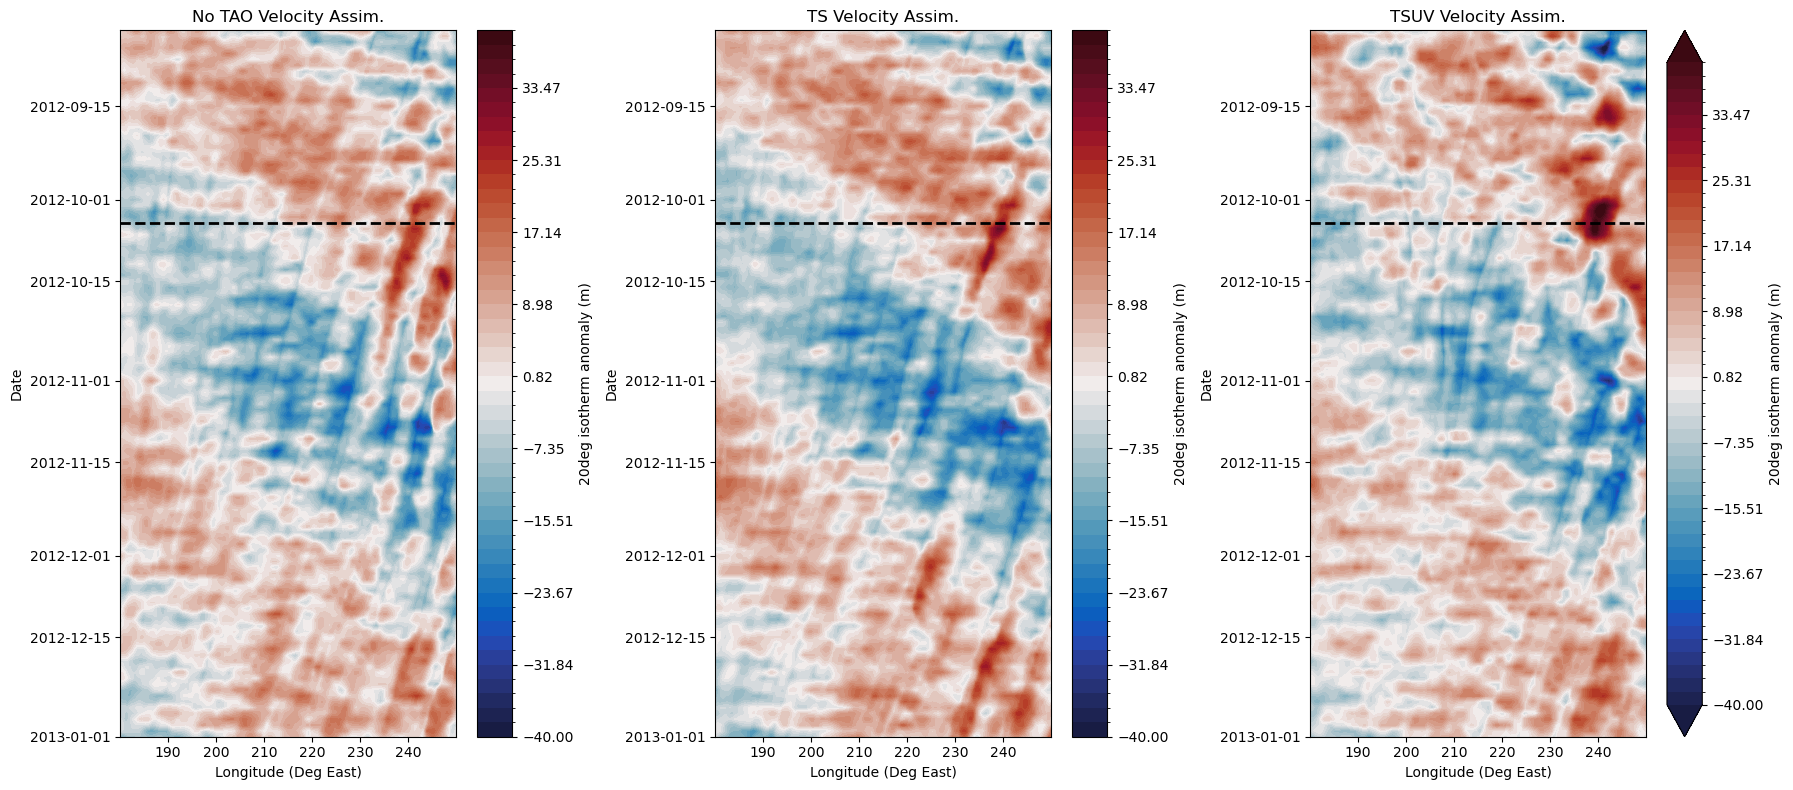

In [34]:
fig, ax = plt.subplots(figsize=(18,8), ncols=3)

vmin = -40
vmax = 40
levels = np.linspace(vmin,vmax,50)
Z20_noTAO.plot.contourf(levels=levels,ax=ax[0],x='XC',cmap=cmo.balance,vmin=vmin,vmax=vmax,cbar_kwargs={'label':'20deg isotherm anomaly (m)'})
ax[0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0].set_xlabel('Longitude (Deg East)')
ax[0].set_ylabel('Date')
ax[0].set_title('Iteration 0')
ax[0].invert_yaxis()

Z20.plot.contourf(levels=levels,ax=ax[1],x='XC',cmap=cmo.balance,vmin=vmin,vmax=vmax,cbar_kwargs={'label':'20deg isotherm anomaly (m)'})
ax[1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1].set_xlabel('Longitude (Deg East)')
ax[1].set_ylabel('Date')
ax[1].set_title('Assimilation + TAO T,S')
ax[1].invert_yaxis()

Z20_vel.plot.contourf(levels=levels,ax=ax[2],x='XC',cmap=cmo.balance,vmin=vmin,vmax=vmax,cbar_kwargs={'label':'20deg isotherm anomaly (m)'})
ax[2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[2].set_xlabel('Longitude (Deg East)')
ax[2].set_ylabel('Date')
ax[2].set_title('Assimilation + TAO TSUV')
ax[2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_20deg_isotherm.png'
plt.savefig(folder_name+image_str,format='png')

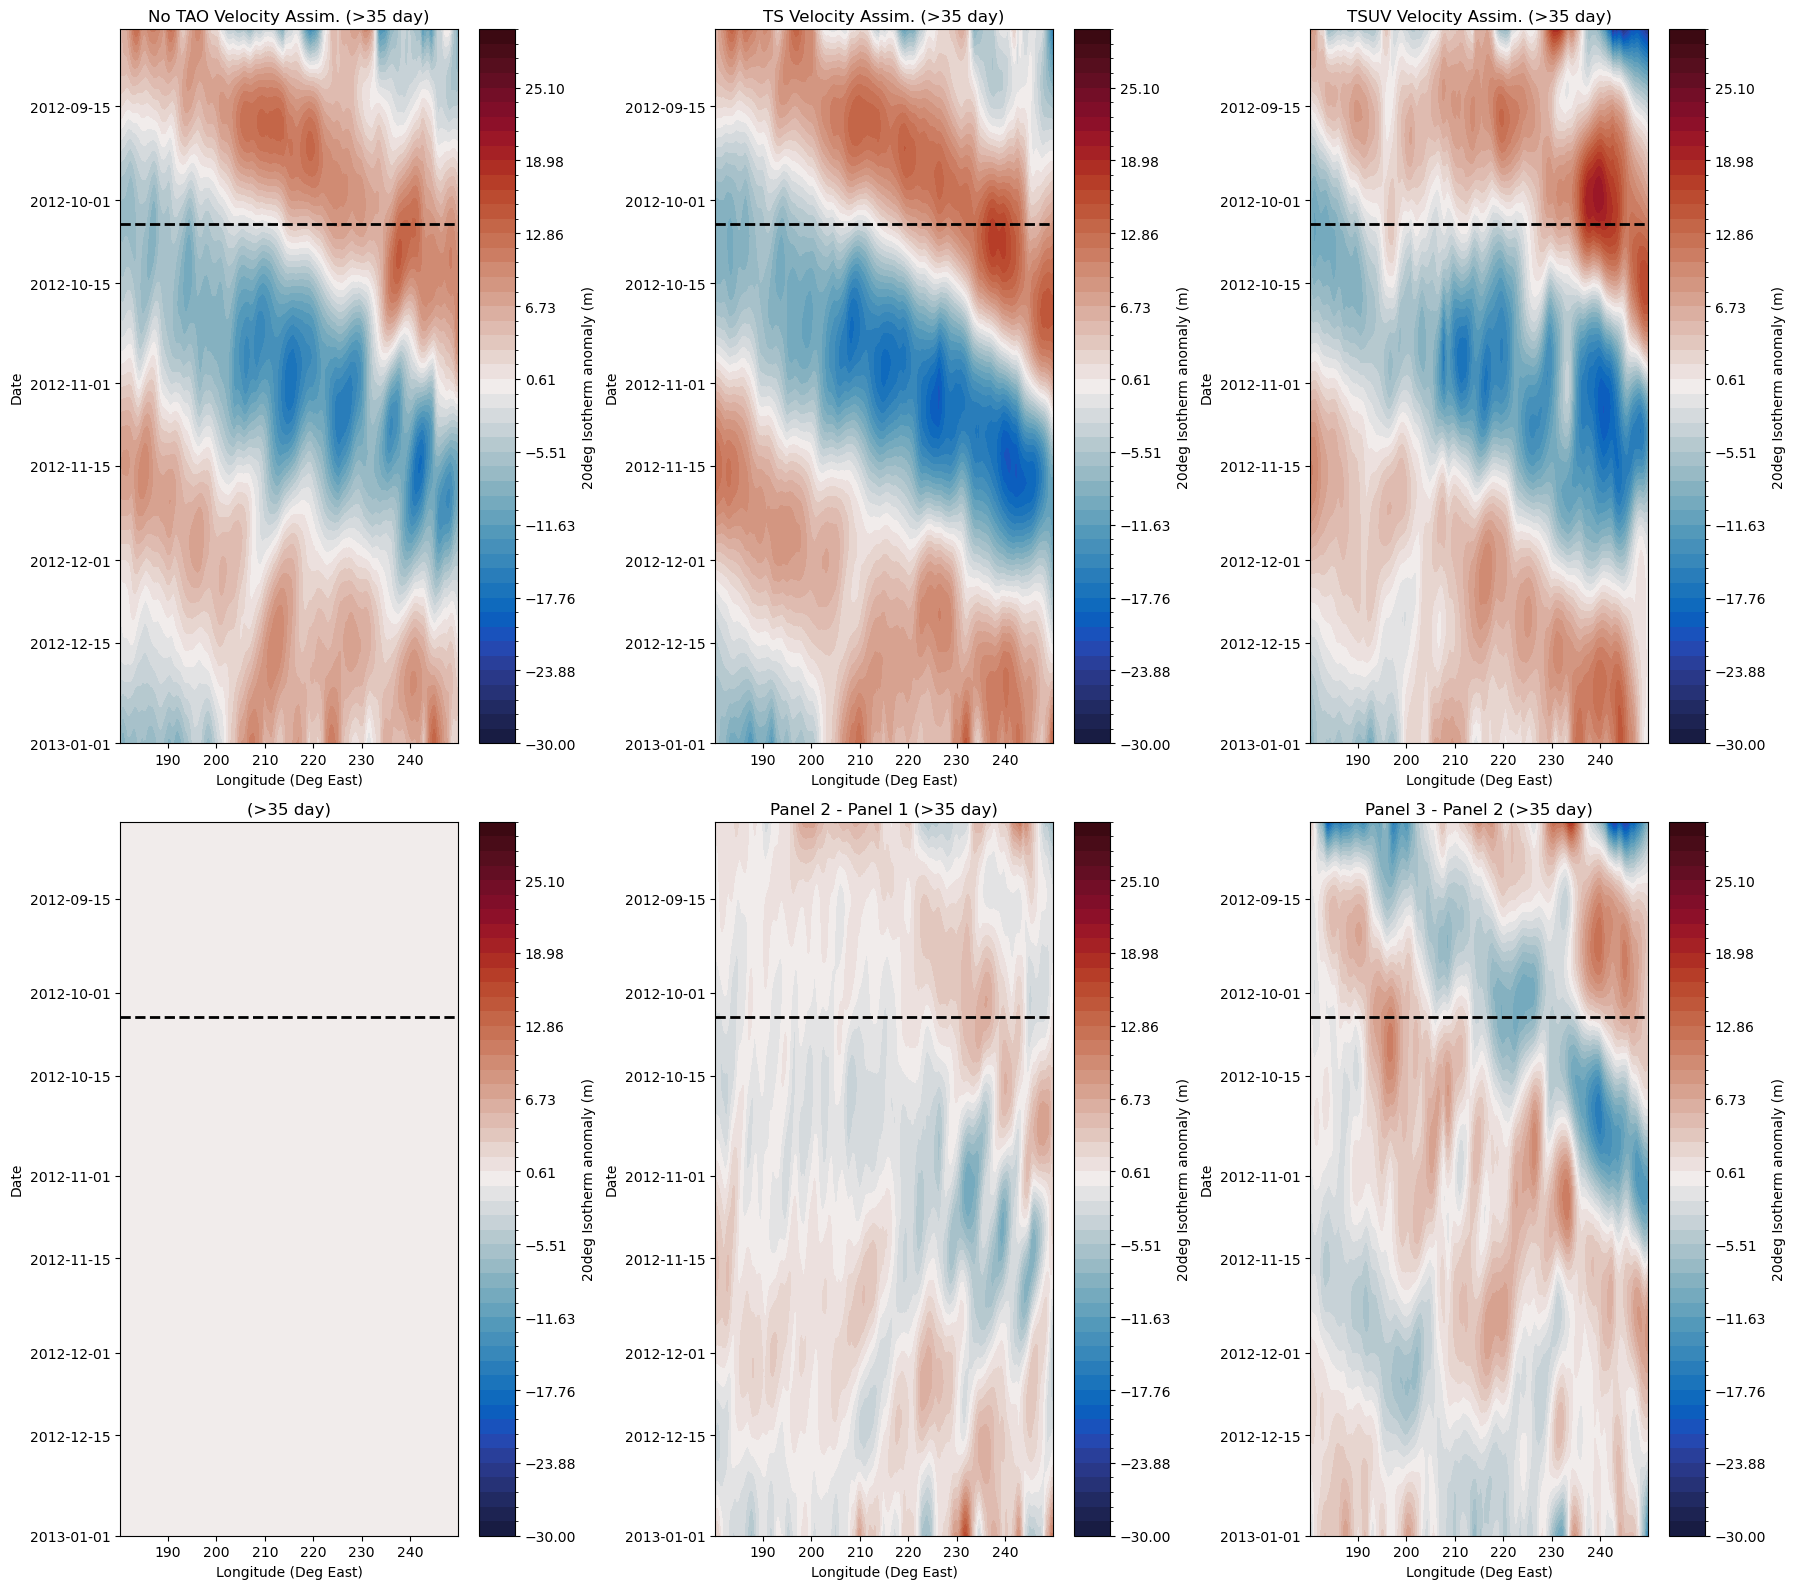

In [35]:
# filtering out high frequency changes
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
highF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, cutoff, 'lowpass', fs=fs, output='sos')

Z20_filt = signal.sosfiltfilt(sos, Z20, axis=0)
Z20_filt_vel = signal.sosfiltfilt(sos, Z20_vel, axis=0)
Z20_filt_noTAO = signal.sosfiltfilt(sos, Z20_noTAO, axis=0)

Z20_filt = xr.DataArray(
    Z20_filt,
    dims=('time', 'XC'),
    coords={'time': theta_noTAO.time, 'XC': theta_noTAO.XC},
    name='Z20'
)

Z20_filt_vel = xr.DataArray(
    Z20_filt_vel,
    dims=('time', 'XC'),
    coords={'time': theta_noTAO.time, 'XC': theta_noTAO.XC},
    name='Z20'
)

Z20_filt_noTAO = xr.DataArray(
    Z20_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': theta_noTAO.time, 'XC': theta_noTAO.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3,nrows=2)

vmin = -30
vmax = 30
levels = np.linspace(vmin,vmax,50)
Z20_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (>35 day)')
ax[0,0].invert_yaxis()

Z20_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (>35 day)')
ax[0,1].invert_yaxis()

Z20_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (>35 day)')
ax[0,2].invert_yaxis()

(Z20_filt_noTAO - Z20_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('(>35 day)')
ax[1,0].invert_yaxis()

(Z20_filt - Z20_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (>35 day)')
ax[1,1].invert_yaxis()

(Z20_filt_vel - Z20_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (>35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_20deg_isotherm_lowPass.png'
plt.savefig(folder_name+image_str,format='png')


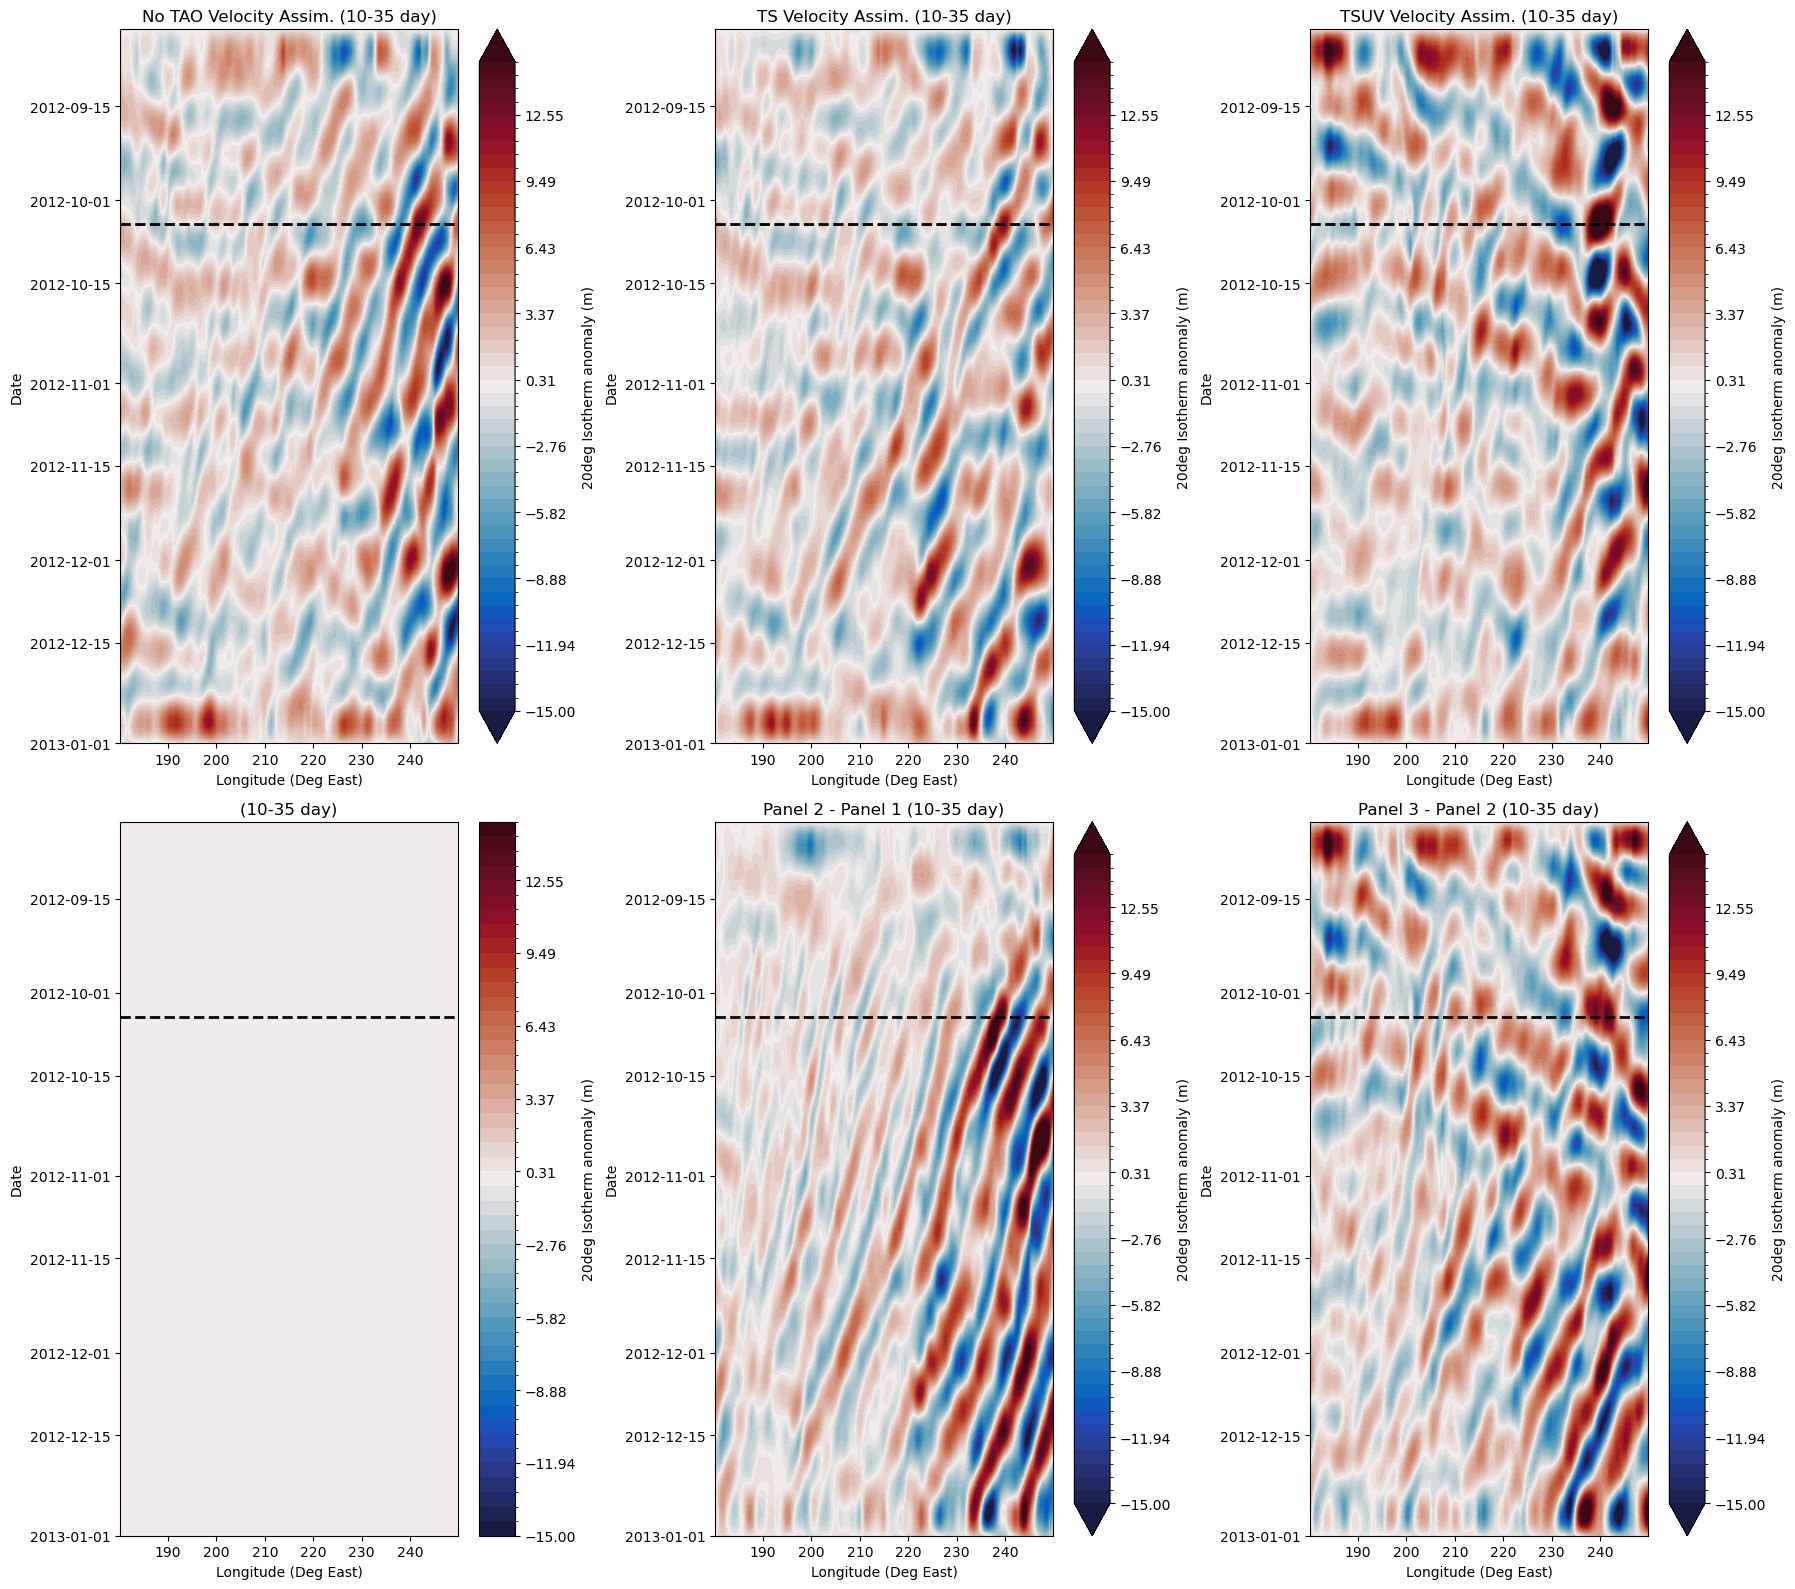

In [36]:
# filtering out high frequency changes
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
lowF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
highF = (1/10)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, [lowF, highF], 'bandpass', fs=fs, output='sos')

Z20_filt = signal.sosfiltfilt(sos, Z20, axis=0)
Z20_filt_vel = signal.sosfiltfilt(sos, Z20_vel, axis=0)
Z20_filt_noTAO = signal.sosfiltfilt(sos, Z20_noTAO, axis=0)

Z20_filt = xr.DataArray(
    Z20_filt,
    dims=('time', 'XC'),
    coords={'time': theta_noTAO.time, 'XC': theta_noTAO.XC},
    name='Z20'
)

Z20_filt_vel = xr.DataArray(
    Z20_filt_vel,
    dims=('time', 'XC'),
    coords={'time': theta_noTAO.time, 'XC': theta_noTAO.XC},
    name='Z20'
)

Z20_filt_noTAO = xr.DataArray(
    Z20_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': theta_noTAO.time, 'XC': theta_noTAO.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3,nrows=2)

vmin = -15
vmax = 15
levels = np.linspace(vmin,vmax,50)
Z20_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (10-35 day)')
ax[0,0].invert_yaxis()

Z20_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (10-35 day)')
ax[0,1].invert_yaxis()

Z20_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (10-35 day)')
ax[0,2].invert_yaxis()

(Z20_filt_noTAO - Z20_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('(10-35 day)')
ax[1,0].invert_yaxis()

(Z20_filt - Z20_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (10-35 day)')
ax[1,1].invert_yaxis()

(Z20_filt_vel - Z20_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'20deg Isotherm anomaly (m)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (10-35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_20deg_isotherm_bandpass.png'
plt.savefig(folder_name+image_str,format='png')

In [14]:
latMin = -0.1
latMax = 0.1
lon=220.0

ETAN = ds.ETAN.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
ETAN_vel = ds_vel.ETAN.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
ETAN_noTAO = ds_noTAO.ETAN.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()

etan = signal.detrend(ETAN, axis=0)
etan = etan - etan.mean()

# Build the DataArray with appropriate coordinates
etan = xr.DataArray(
    etan,
    dims=('time', 'XC'),
    coords={'time': ETAN.time, 'XC': ETAN.XC},
    name='etan anomaly'
)

etan_vel = signal.detrend(ETAN_vel, axis=0)
etan_vel = etan_vel - etan_vel.mean()

# Build the DataArray with appropriate coordinates
etan_vel = xr.DataArray(
    etan_vel,
    dims=('time', 'XC'),
    coords={'time': ETAN_vel.time, 'XC': ETAN_vel.XC},
    name='etan anomaly'
)

etan_noTAO = signal.detrend(ETAN_noTAO, axis=0)
etan_vel = etan_vel - etan_vel.mean()

# Build the DataArray with appropriate coordinates
etan_noTAO = xr.DataArray(
    etan_noTAO,
    dims=('time', 'XC'),
    coords={'time': ETAN_noTAO.time, 'XC': ETAN_noTAO.XC},
    name='etan anomaly'
)


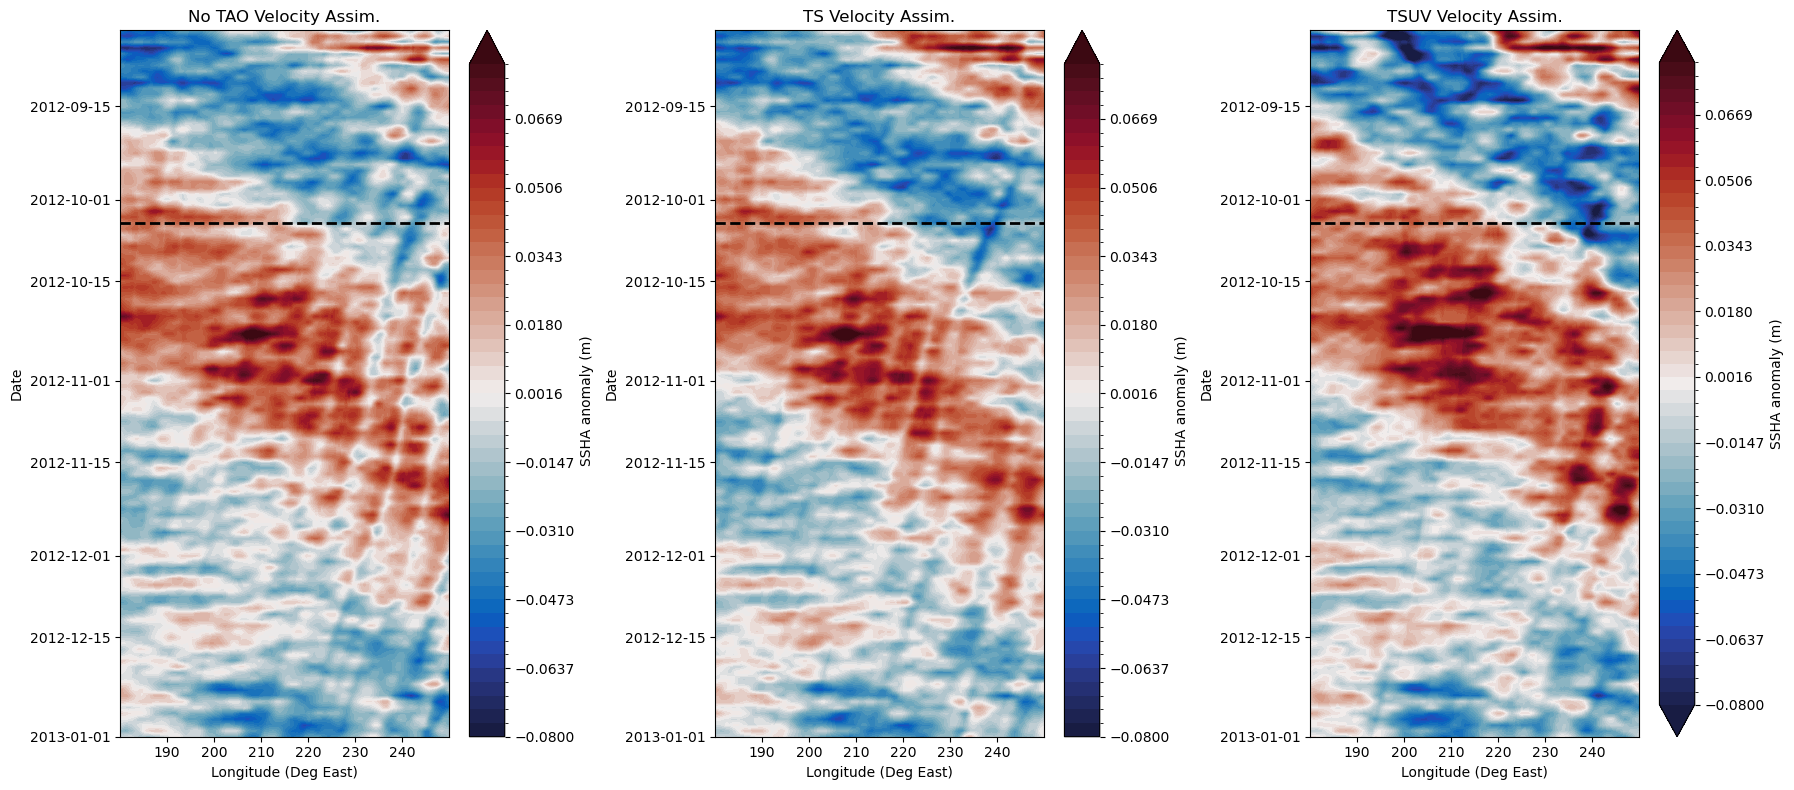

In [15]:
fig, ax = plt.subplots(figsize=(18,8), ncols=3)
vmin = -0.08
vmax = 0.08
levels = np.linspace(vmin,vmax,50)
etan_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0].set_xlabel('Longitude (Deg East)')
ax[0].set_ylabel('Date')
ax[0].set_title('Iteration 0')
ax[0].invert_yaxis()

etan.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1].set_xlabel('Longitude (Deg East)')
ax[1].set_ylabel('Date')
ax[1].set_title('Assimilation + TAO T,S')
ax[1].invert_yaxis()

etan_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[2].set_xlabel('Longitude (Deg East)')
ax[2].set_ylabel('Date')
ax[2].set_title('Assimilation + TAO TSUV')
ax[2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_ssh.png'
plt.savefig(folder_name+image_str,format='png')

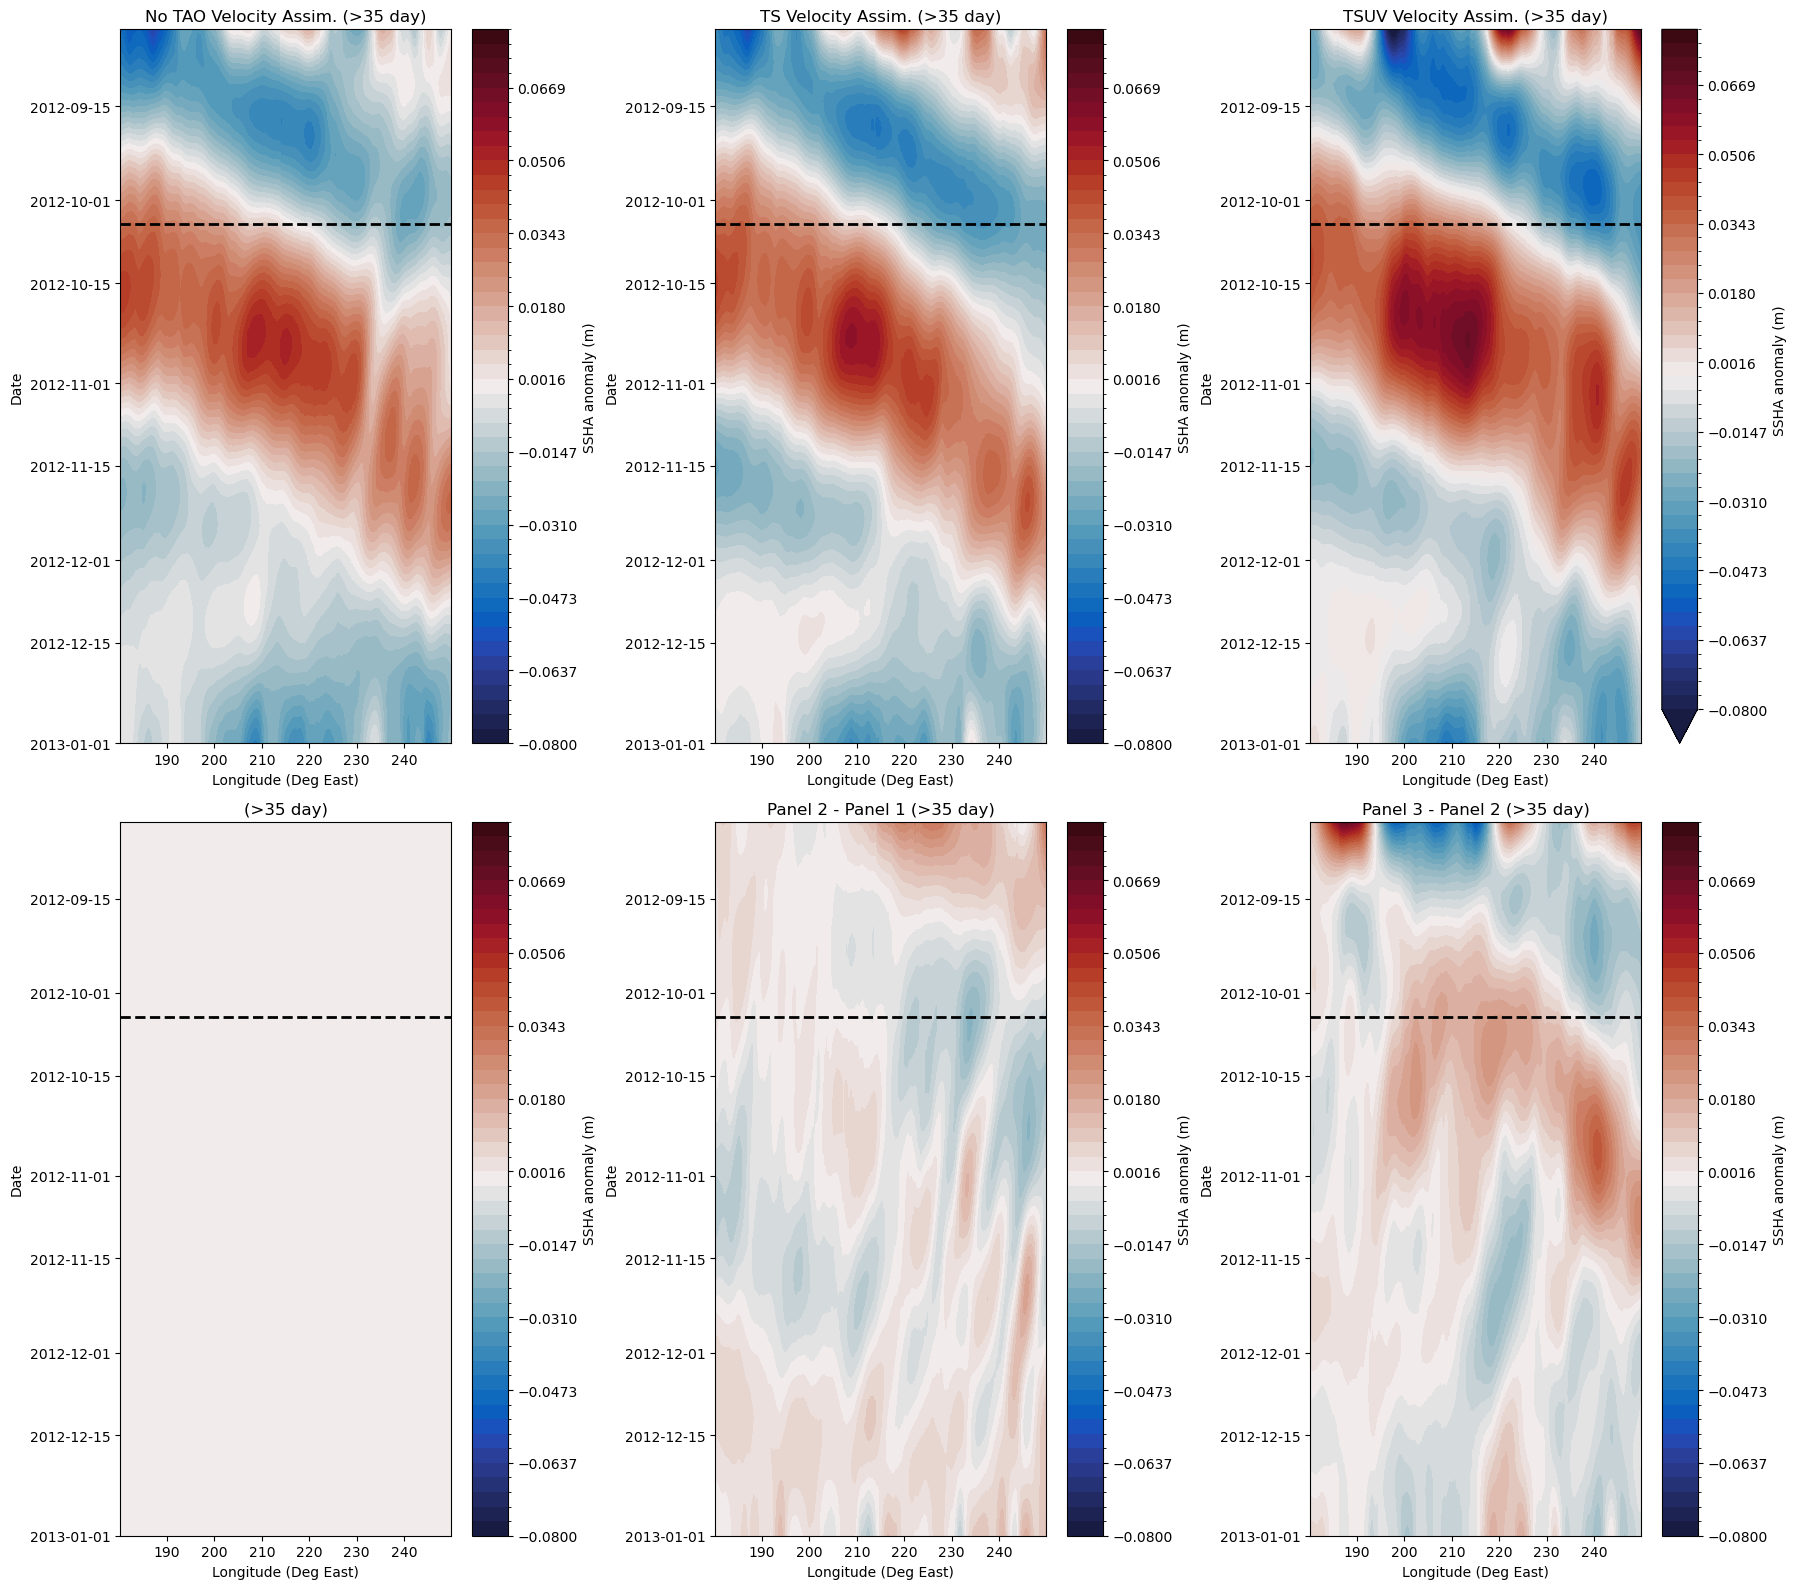

In [18]:
# filtering out high frequency changes
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
highF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, cutoff, 'lowpass', fs=fs, output='sos')

etan_filt = signal.sosfiltfilt(sos, etan, axis=0)
etan_filt_vel = signal.sosfiltfilt(sos, etan_vel, axis=0)
etan_filt_noTAO = signal.sosfiltfilt(sos, etan_noTAO, axis=0)

etan_filt = xr.DataArray(
    etan_filt,
    dims=('time', 'XC'),
    coords={'time': ETAN.time, 'XC': ETAN.XC},
    name='Z20'
)

etan_filt_vel = xr.DataArray(
    etan_filt_vel,
    dims=('time', 'XC'),
    coords={'time': ETAN_vel.time, 'XC': ETAN_vel.XC},
    name='Z20'
)

etan_filt_noTAO = xr.DataArray(
    etan_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': ETAN_noTAO.time, 'XC': ETAN_noTAO.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3,nrows=2)

vmin = -0.08
vmax = 0.08
levels = np.linspace(vmin,vmax,50)
etan_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (>35 day)')
ax[0,0].invert_yaxis()

etan_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (>35 day)')
ax[0,1].invert_yaxis()

etan_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (>35 day)')
ax[0,2].invert_yaxis()

(etan_filt_noTAO - etan_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('(>35 day)')
ax[1,0].invert_yaxis()

(etan_filt - etan_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (>35 day)')
ax[1,1].invert_yaxis()

(etan_filt_vel - etan_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (>35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_ssh_lowPass.png'
plt.savefig(folder_name+image_str,format='png')


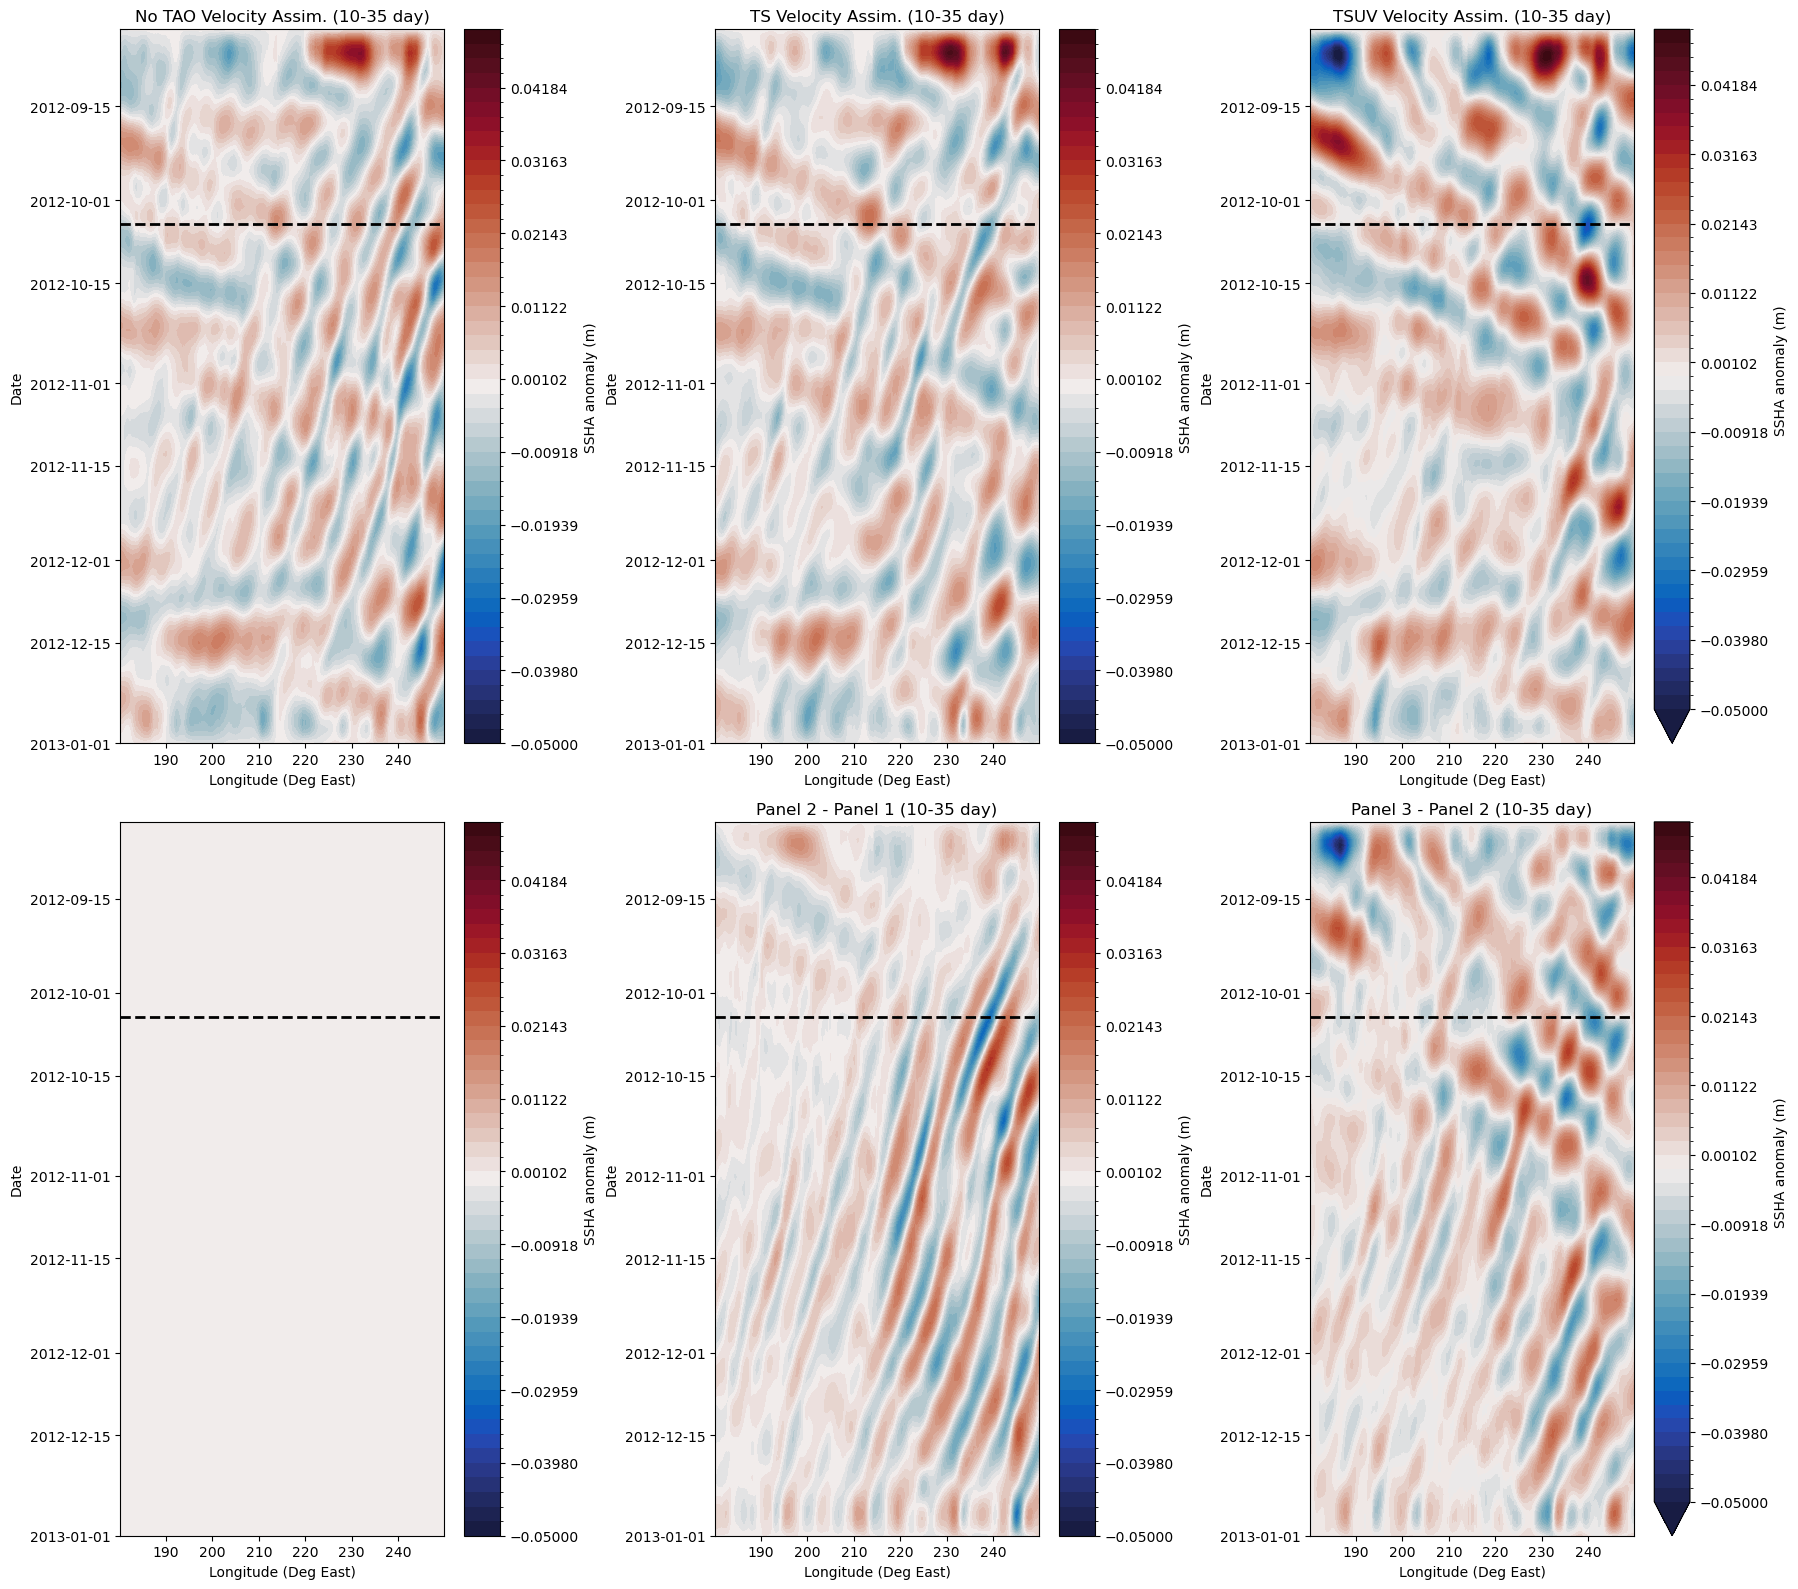

In [17]:
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
lowF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
highF = (1/10)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, [lowF, highF], 'bandpass', fs=fs, output='sos')

etan_filt = signal.sosfiltfilt(sos, etan, axis=0)
etan_filt_vel = signal.sosfiltfilt(sos, etan_vel, axis=0)
etan_filt_noTAO = signal.sosfiltfilt(sos, etan_noTAO, axis=0)

etan_filt = xr.DataArray(
    etan_filt,
    dims=('time', 'XC'),
    coords={'time': ETAN.time, 'XC': ETAN.XC},
    name='Z20'
)

etan_filt_vel = xr.DataArray(
    etan_filt_vel,
    dims=('time', 'XC'),
    coords={'time': ETAN_vel.time, 'XC': ETAN_vel.XC},
    name='Z20'
)

etan_filt_noTAO = xr.DataArray(
    etan_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': ETAN_noTAO.time, 'XC': ETAN_noTAO.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3, nrows=2)

vmin = -0.05
vmax = 0.05
levels = np.linspace(vmin,vmax,50)
etan_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (10-35 day)')
ax[0,0].invert_yaxis()

etan_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (10-35 day)')
ax[0,1].invert_yaxis()

etan_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (10-35 day)')
ax[0,2].invert_yaxis()

(etan_filt_noTAO - etan_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('')
ax[1,0].invert_yaxis()

(etan_filt - etan_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (10-35 day)')
ax[1,1].invert_yaxis()

(etan_filt_vel - etan_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'SSHA anomaly (m)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (10-35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_ssh_bandpass.png'
plt.savefig(folder_name+image_str,format='png')


In [19]:
latMin = -0.1
latMax = 0.1

TAUX = ds.EXFtaux.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
TAUX_vel = ds_vel.EXFtaux.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
TAUX_noTAO = ds_noTAO.EXFtaux.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()

taux = signal.detrend(TAUX, axis=0)
taux = taux - taux.mean()

# Build the DataArray with appropriate coordinates
taux = xr.DataArray(
    taux,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='etan anomaly'
)

taux_vel = signal.detrend(TAUX_vel, axis=0)
taux_vel = taux_vel - taux_vel.mean()

# Build the DataArray with appropriate coordinates
taux_vel = xr.DataArray(
    taux_vel,
    dims=('time', 'XC'),
    coords={'time': TAUX_vel.time, 'XC': TAUX_vel.XC},
    name='etan anomaly'
)

taux_noTAO = signal.detrend(TAUX_noTAO, axis=0)
taux_noTAO = taux_noTAO - taux_noTAO.mean()

# Build the DataArray with appropriate coordinates
taux_noTAO = xr.DataArray(
    taux_noTAO,
    dims=('time', 'XC'),
    coords={'time': TAUX_noTAO.time, 'XC': TAUX_noTAO.XC},
    name='etan anomaly'
)


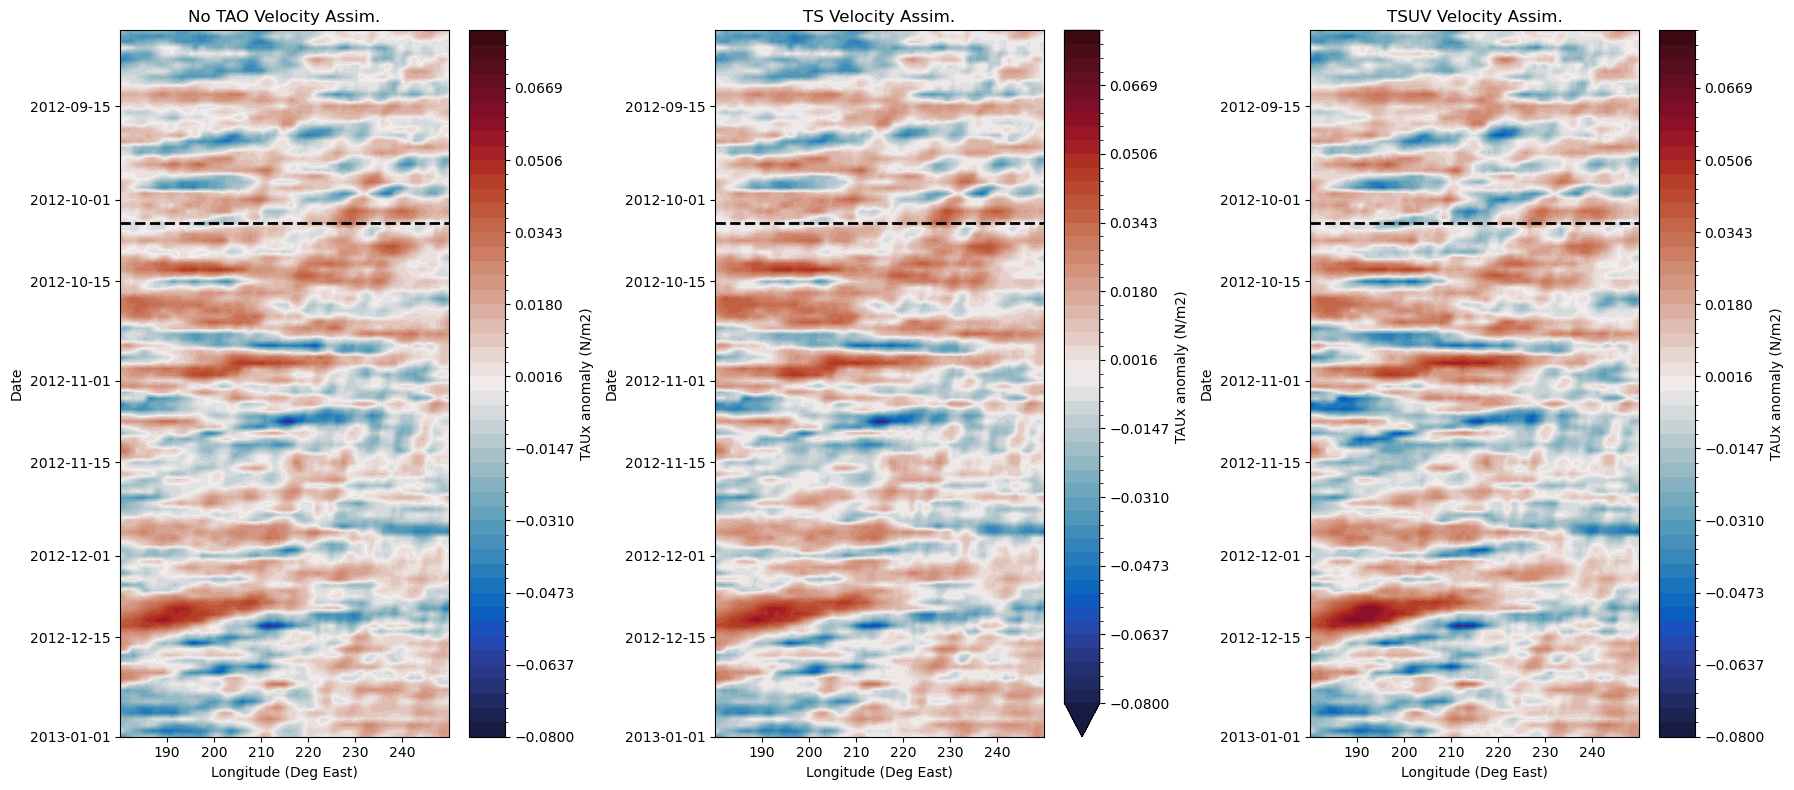

In [20]:
fig, ax = plt.subplots(figsize=(18,8), ncols=3)
vmin = -0.08
vmax = 0.08
levels = np.linspace(vmin,vmax,50)
taux_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0].set_xlabel('Longitude (Deg East)')
ax[0].set_ylabel('Date')
ax[0].set_title('Iteration 0')
ax[0].invert_yaxis()

taux.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1].set_xlabel('Longitude (Deg East)')
ax[1].set_ylabel('Date')
ax[1].set_title('Assimilation + TAO T,S')
ax[1].invert_yaxis()

taux_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[2].set_xlabel('Longitude (Deg East)')
ax[2].set_ylabel('Date')
ax[2].set_title('Assimilation + TAO TSUV')
ax[2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_taux_anomaly.png'
plt.savefig(folder_name+image_str,format='png')

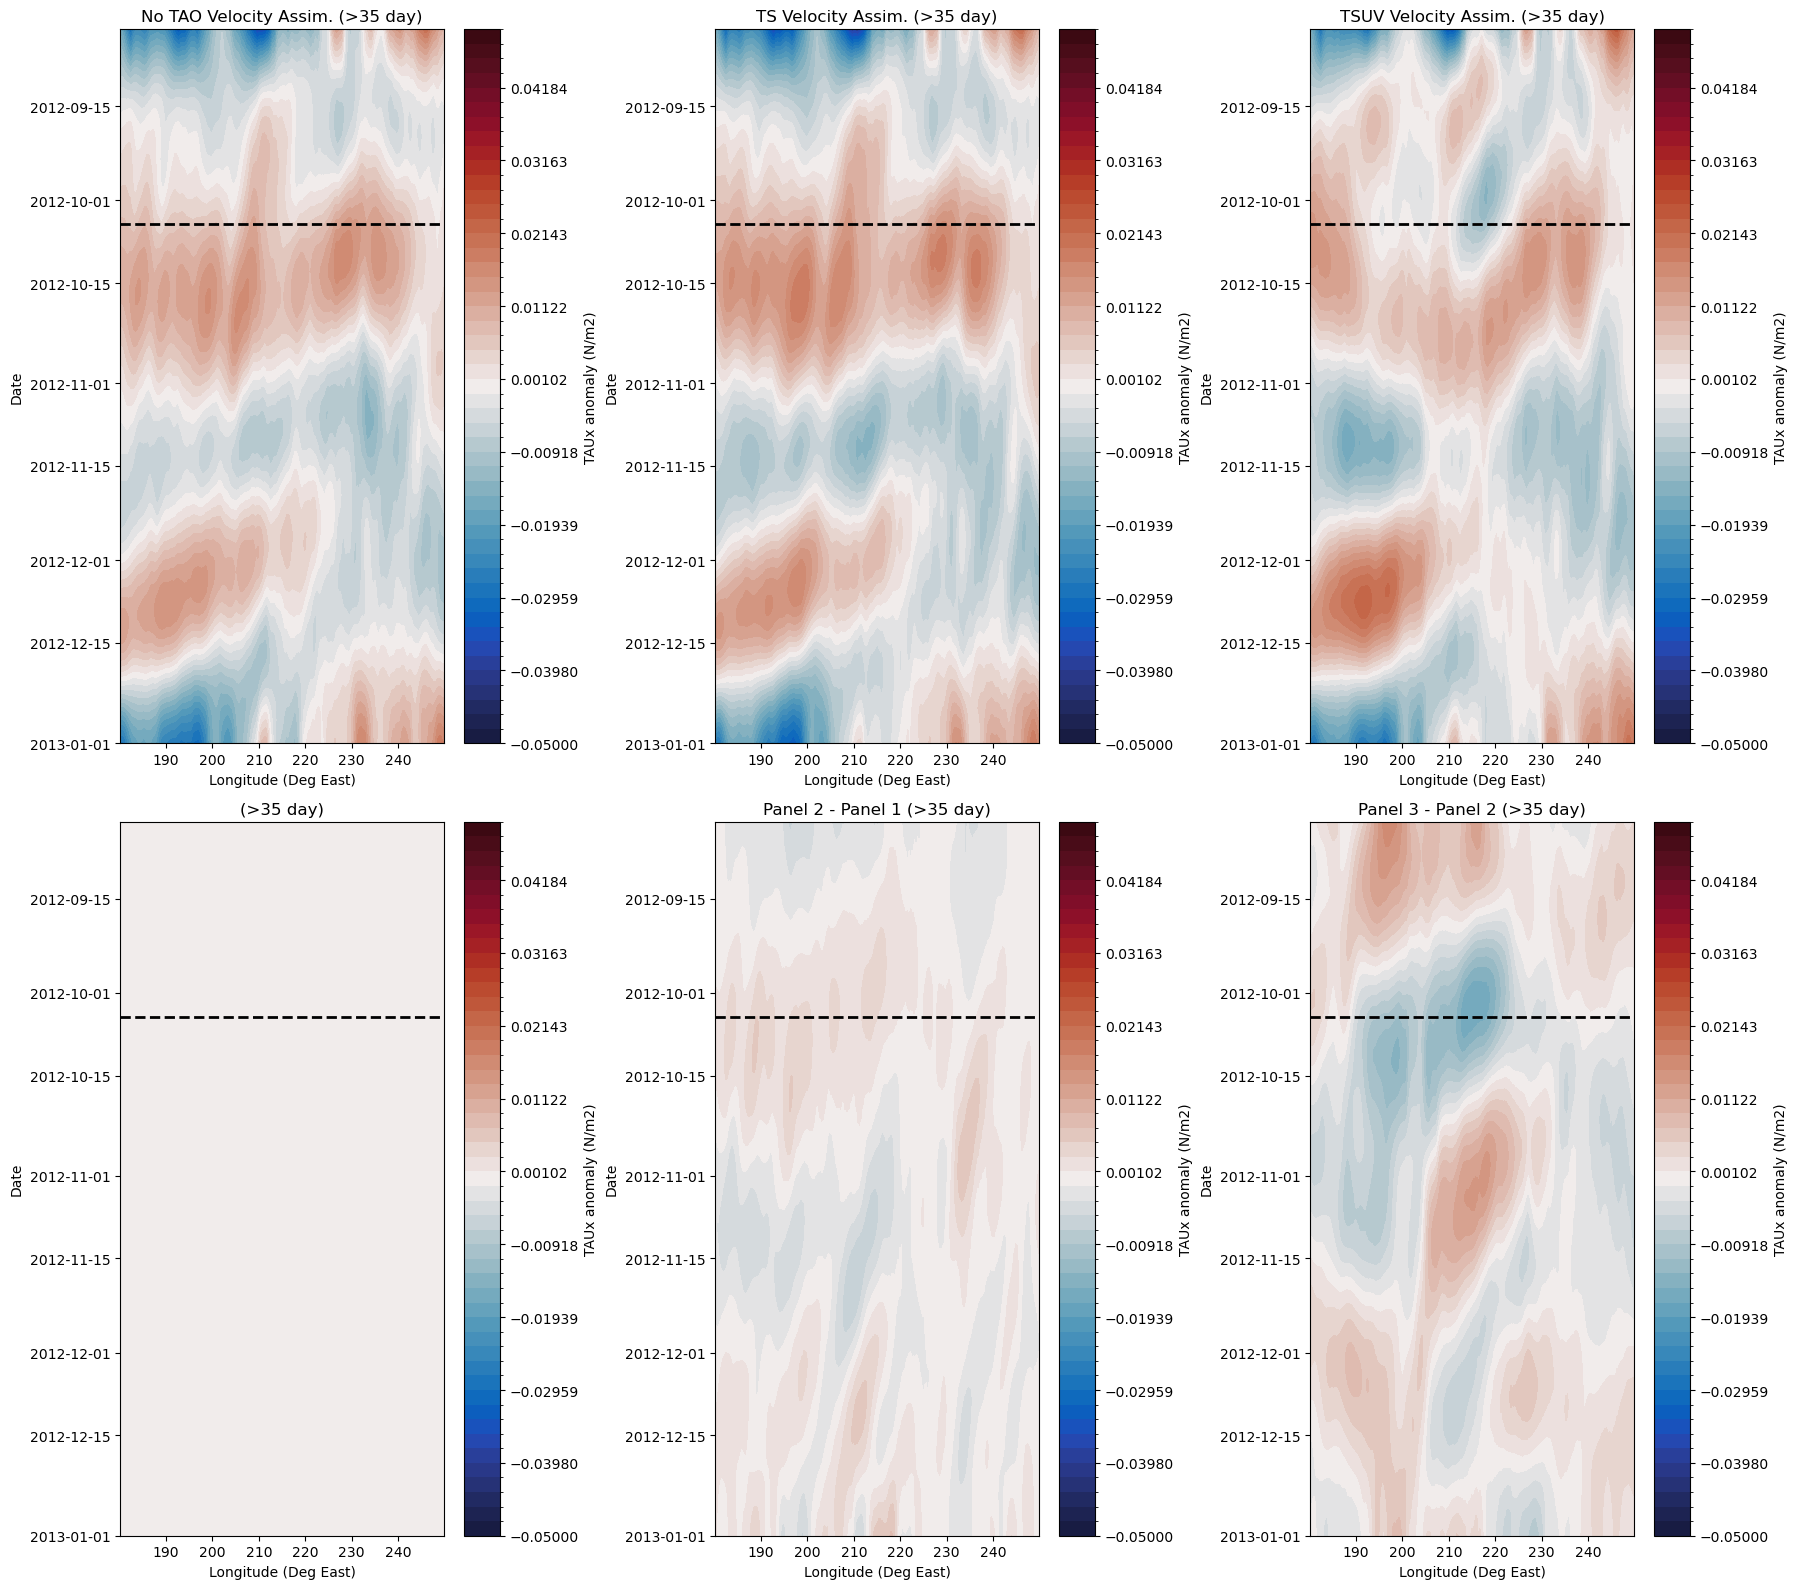

In [22]:
# filtering out high frequency changes
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
highF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, cutoff, 'lowpass', fs=fs, output='sos')

taux_filt = signal.sosfiltfilt(sos, taux, axis=0)
taux_filt_vel = signal.sosfiltfilt(sos, taux_vel, axis=0)
taux_filt_noTAO = signal.sosfiltfilt(sos, taux_noTAO, axis=0)

taux_filt = xr.DataArray(
    taux_filt,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_vel = xr.DataArray(
    taux_filt_vel,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_noTAO = xr.DataArray(
    taux_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3,nrows=2)

vmin = -0.05
vmax = 0.05
levels = np.linspace(vmin,vmax,50)
taux_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (>35 day)')
ax[0,0].invert_yaxis()

taux_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (>35 day)')
ax[0,1].invert_yaxis()

taux_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (>35 day)')
ax[0,2].invert_yaxis()

(taux_filt_noTAO - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('(>35 day)')
ax[1,0].invert_yaxis()

(taux_filt - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (>35 day)')
ax[1,1].invert_yaxis()

(taux_filt_vel - taux_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (>35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_taux_lowPass.png'
plt.savefig(folder_name+image_str,format='png')


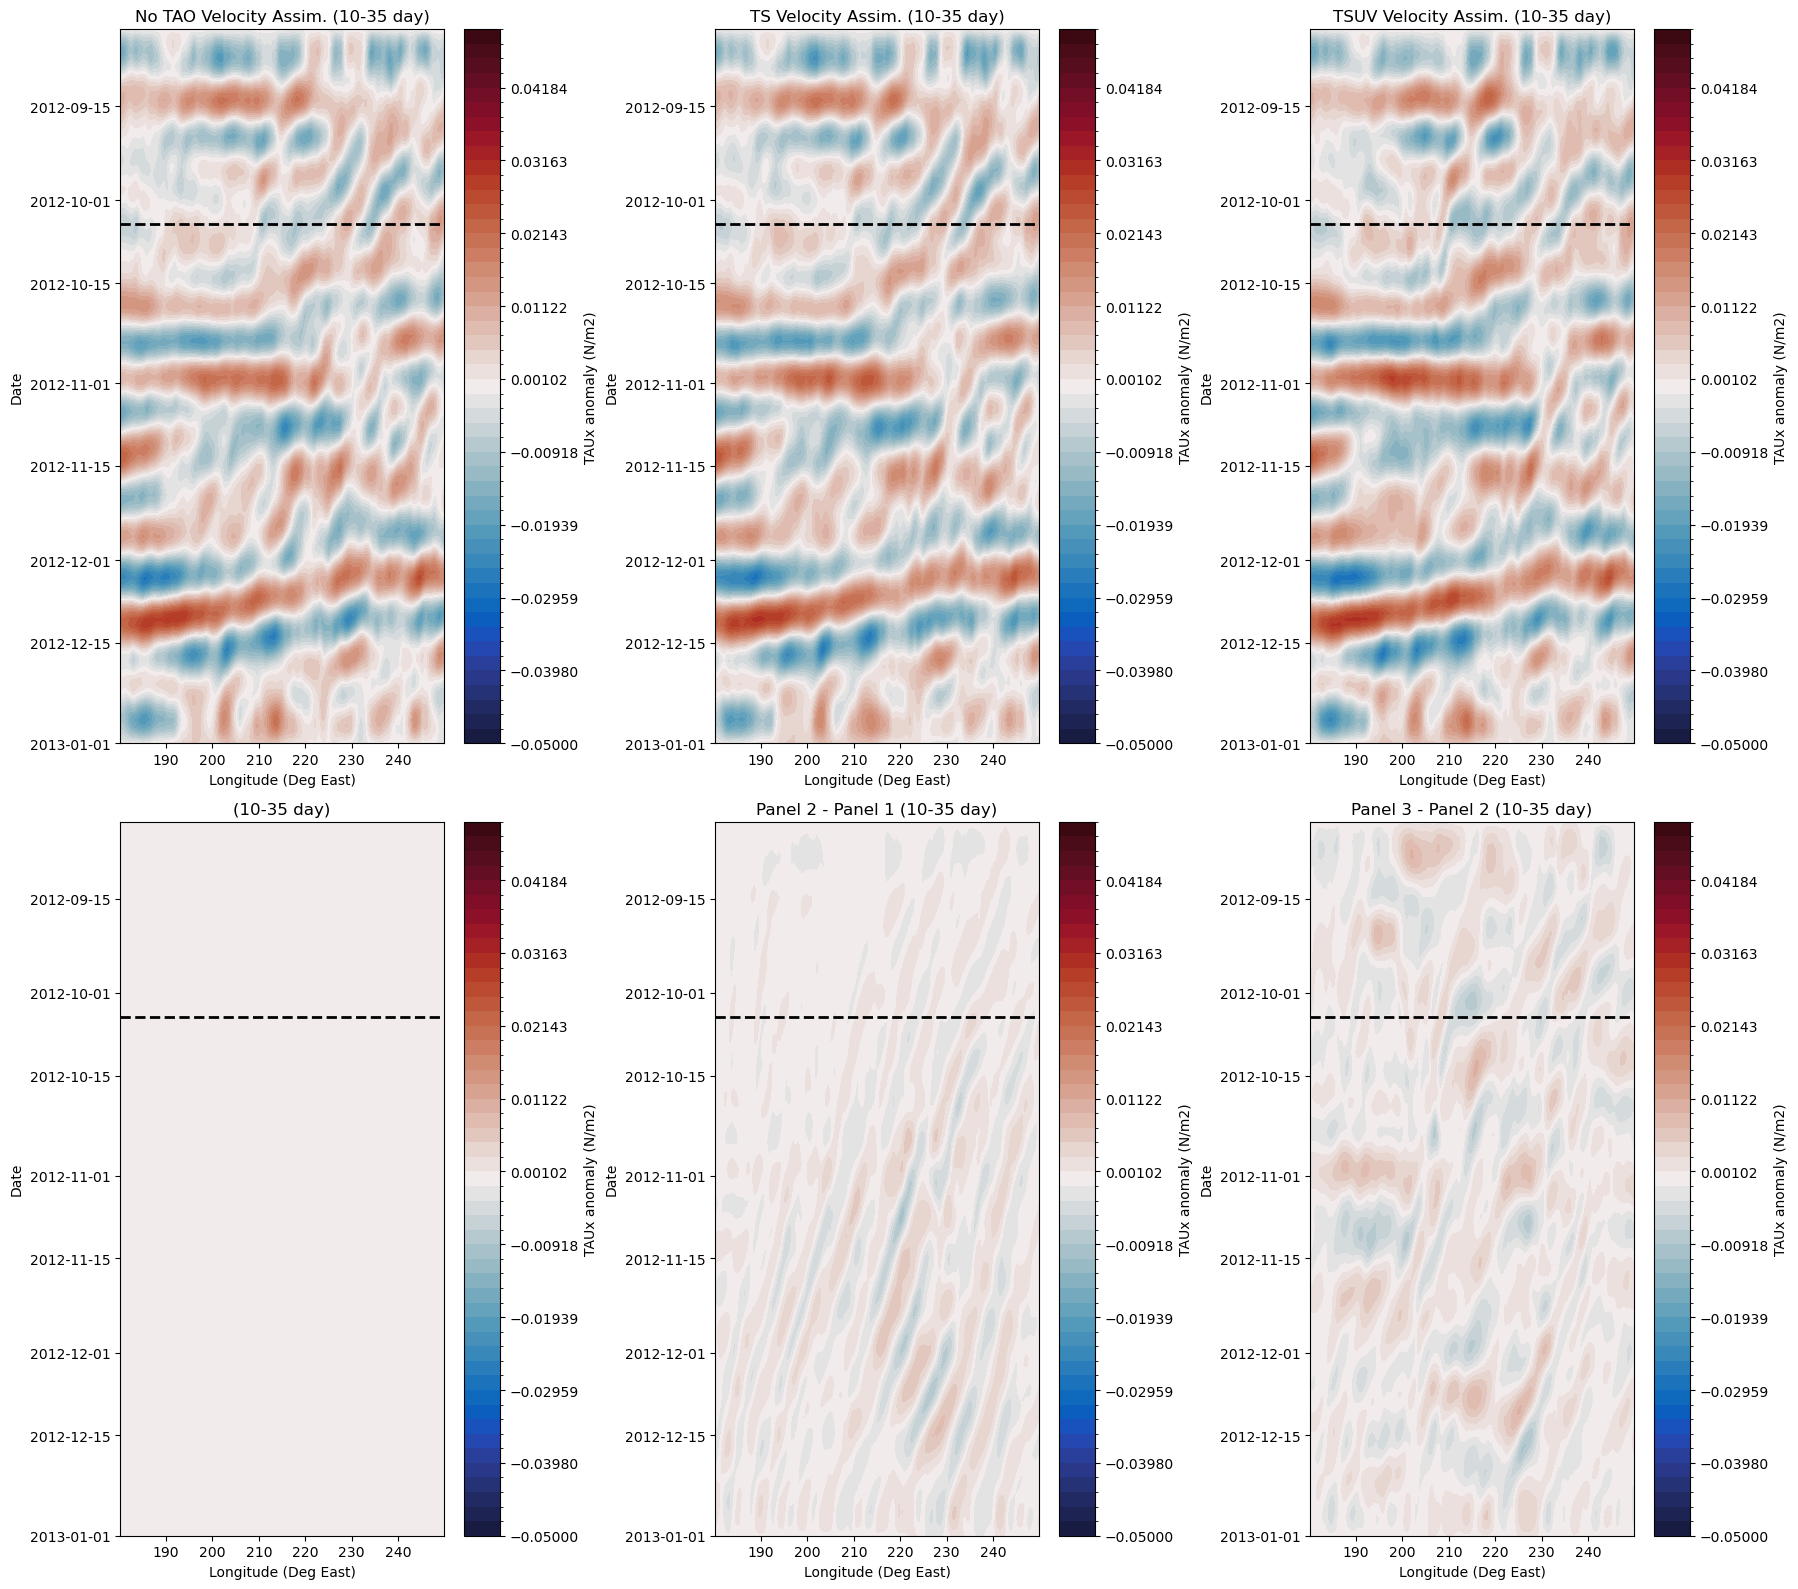

In [23]:
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
lowF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
highF = (1/10)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, [lowF, highF], 'bandpass', fs=fs, output='sos')

taux_filt = signal.sosfiltfilt(sos, taux, axis=0)
taux_filt_vel = signal.sosfiltfilt(sos, taux_vel, axis=0)
taux_filt_noTAO = signal.sosfiltfilt(sos, taux_noTAO, axis=0)

taux_filt = xr.DataArray(
    taux_filt,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_vel = xr.DataArray(
    taux_filt_vel,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_noTAO = xr.DataArray(
    taux_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3,nrows=2)

vmin = -0.05
vmax = 0.05
levels = np.linspace(vmin,vmax,50)
taux_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (10-35 day)')
ax[0,0].invert_yaxis()

taux_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (10-35 day)')
ax[0,1].invert_yaxis()

taux_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (10-35 day)')
ax[0,2].invert_yaxis()

(taux_filt_noTAO - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('(10-35 day)')
ax[1,0].invert_yaxis()

(taux_filt - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (10-35 day)')
ax[1,1].invert_yaxis()

(taux_filt_vel - taux_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUx anomaly (N/m2)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (10-35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_taux_bandpass.png'
plt.savefig(folder_name+image_str,format='png')


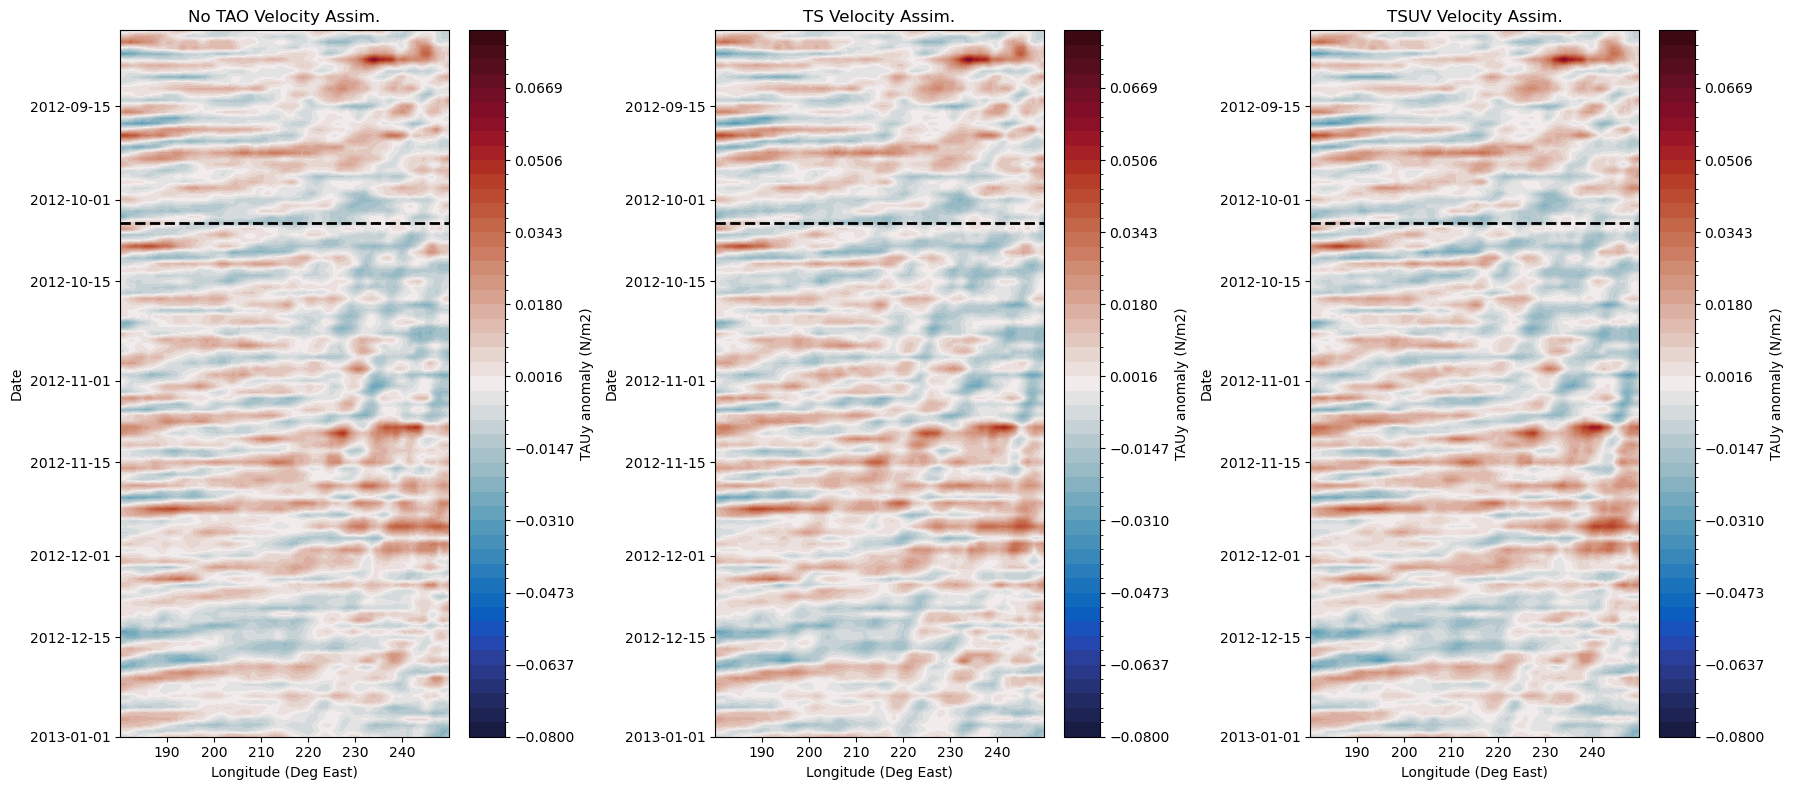

In [24]:
latMin = -0.1
latMax = 0.1

TAUX = ds.EXFtauy.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
TAUX_vel = ds_vel.EXFtauy.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()
TAUX_noTAO = ds_noTAO.EXFtauy.sel(YC=slice(latMin,latMax)).sel(XC=slice(180,250)).mean(dim='YC').squeeze().compute()

taux = signal.detrend(TAUX, axis=0)
taux = taux - taux.mean()

# Build the DataArray with appropriate coordinates
taux = xr.DataArray(
    taux,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='etan anomaly'
)

taux_vel = signal.detrend(TAUX_vel, axis=0)
taux_vel = taux_vel - taux_vel.mean()

# Build the DataArray with appropriate coordinates
taux_vel = xr.DataArray(
    taux_vel,
    dims=('time', 'XC'),
    coords={'time': TAUX_vel.time, 'XC': TAUX_vel.XC},
    name='etan anomaly'
)

taux_noTAO = signal.detrend(TAUX_noTAO, axis=0)
taux_noTAO = taux_noTAO - taux_noTAO.mean()

# Build the DataArray with appropriate coordinates
taux_noTAO = xr.DataArray(
    taux_noTAO,
    dims=('time', 'XC'),
    coords={'time': TAUX_noTAO.time, 'XC': TAUX_noTAO.XC},
    name='etan anomaly'
)

fig, ax = plt.subplots(figsize=(18,8), ncols=3)
vmin = -0.08
vmax = 0.08
levels = np.linspace(vmin,vmax,50)
taux_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0].set_xlabel('Longitude (Deg East)')
ax[0].set_ylabel('Date')
ax[0].set_title('Iteration 0')
ax[0].invert_yaxis()

taux.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1].set_xlabel('Longitude (Deg East)')
ax[1].set_ylabel('Date')
ax[1].set_title('Assimilation + TAO T,S')
ax[1].invert_yaxis()

taux_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[2].set_xlabel('Longitude (Deg East)')
ax[2].set_ylabel('Date')
ax[2].set_title('Assimilation + TAO TSUV')
ax[2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_tauy_anomaly.png'
plt.savefig(folder_name+image_str,format='png')

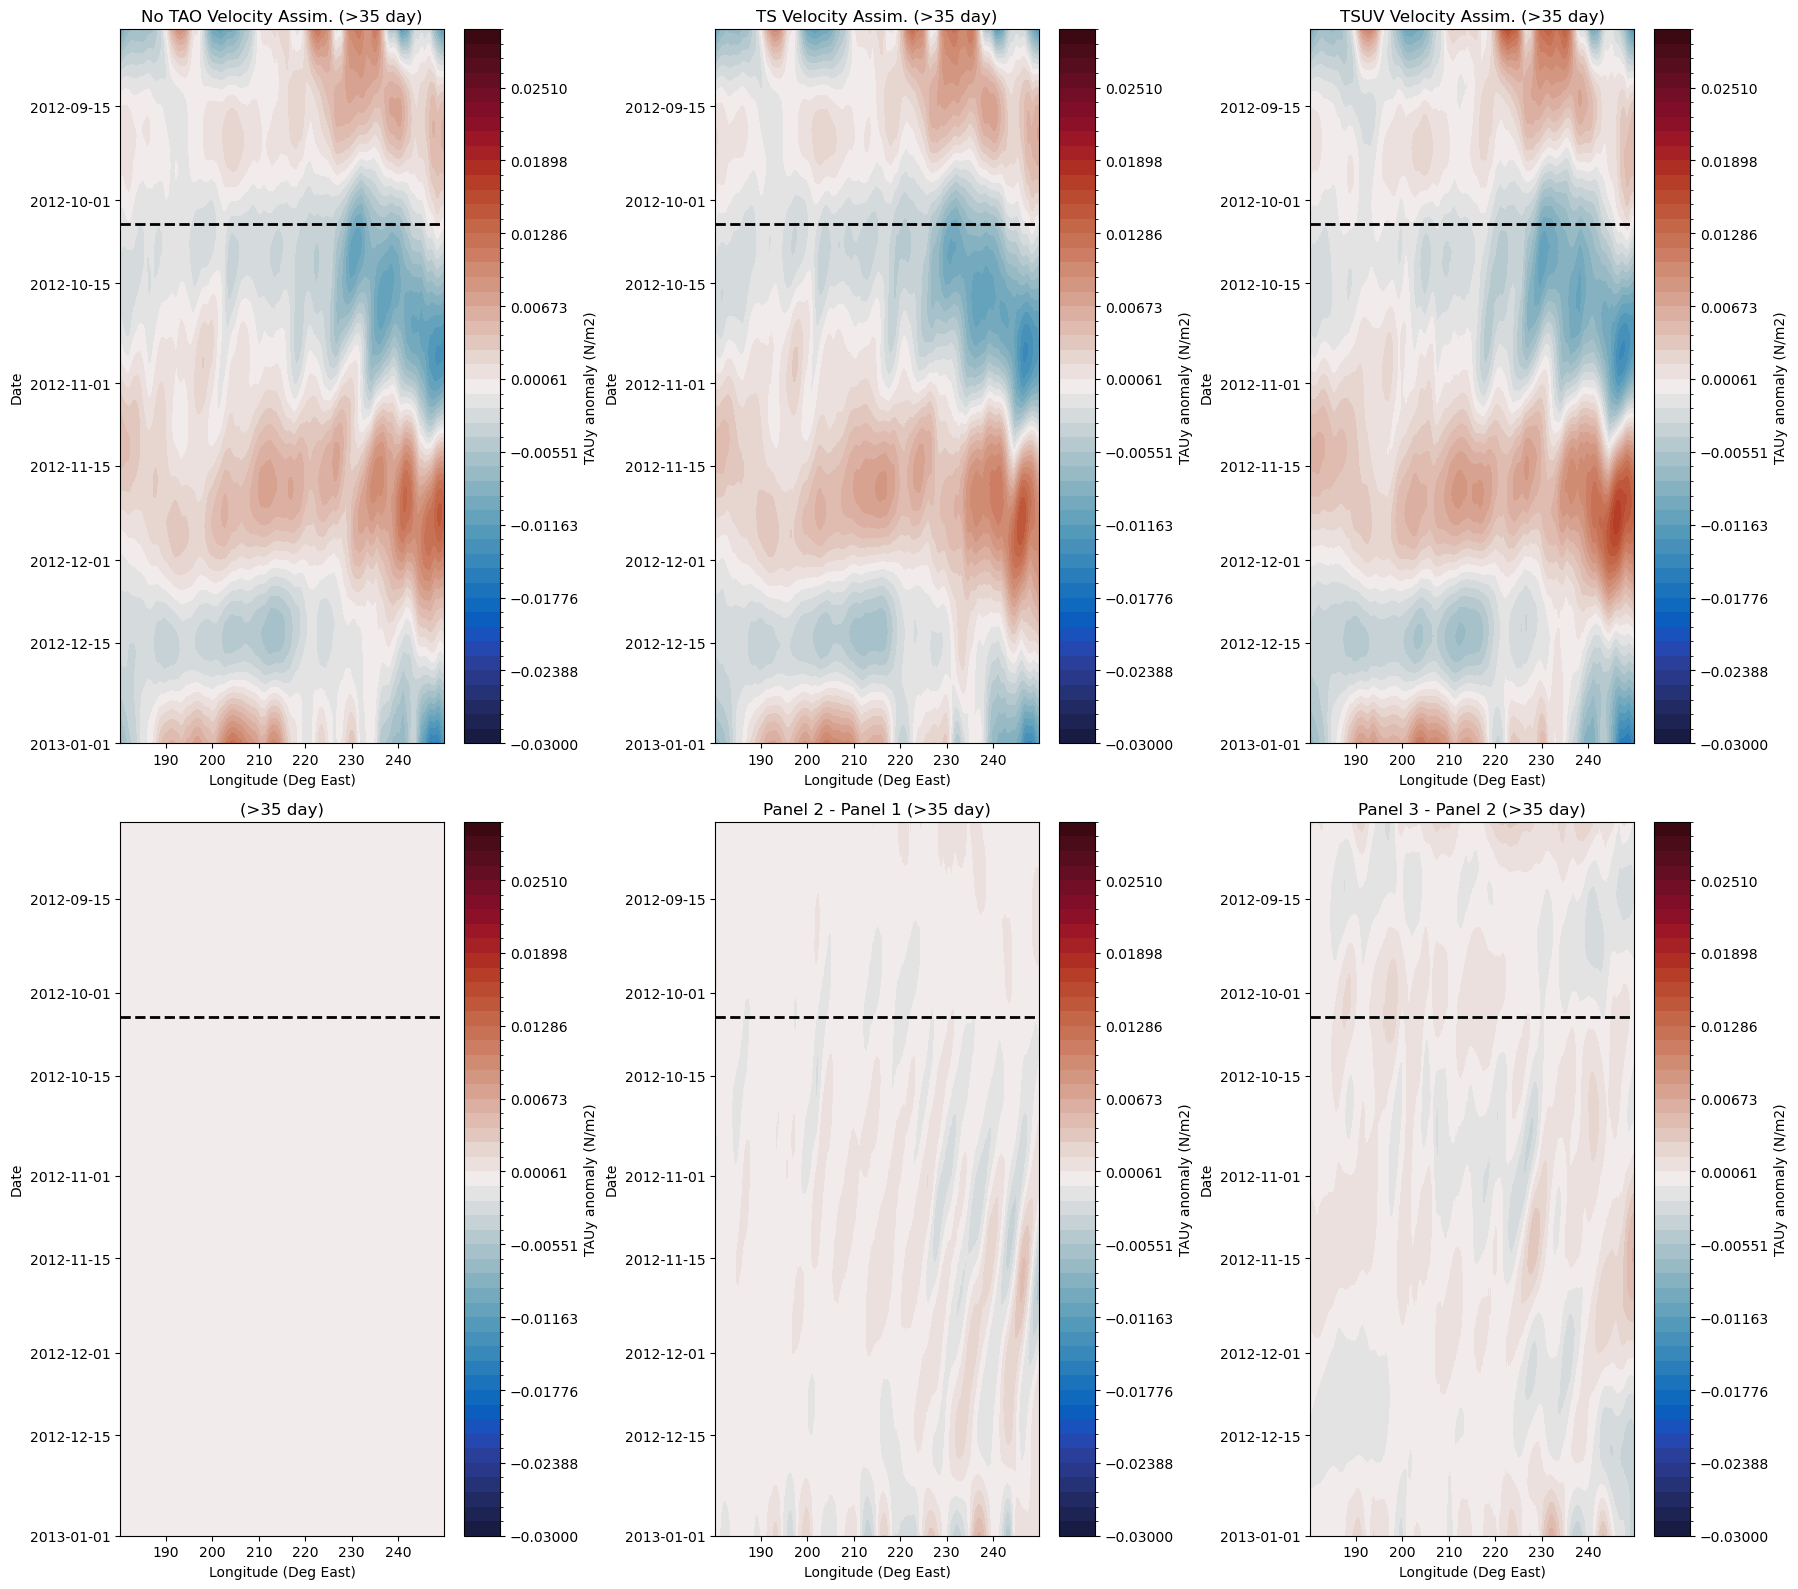

In [26]:
# filtering out high frequency changes
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
highF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, cutoff, 'lowpass', fs=fs, output='sos')

taux_filt = signal.sosfiltfilt(sos, taux, axis=0)
taux_filt_vel = signal.sosfiltfilt(sos, taux_vel, axis=0)
taux_filt_noTAO = signal.sosfiltfilt(sos, taux_noTAO, axis=0)

taux_filt = xr.DataArray(
    taux_filt,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_vel = xr.DataArray(
    taux_filt_vel,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_noTAO = xr.DataArray(
    taux_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3,nrows=2)

vmin = -0.03
vmax = 0.03
levels = np.linspace(vmin,vmax,50)
taux_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (>35 day)')
ax[0,0].invert_yaxis()

taux_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (>35 day)')
ax[0,1].invert_yaxis()

taux_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (>35 day)')
ax[0,2].invert_yaxis()

(taux_filt_noTAO - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('(>35 day)')
ax[1,0].invert_yaxis()

(taux_filt - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (>35 day)')
ax[1,1].invert_yaxis()

(taux_filt_vel - taux_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (>35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_tauy_lowPass.png'
plt.savefig(folder_name+image_str,format='png')


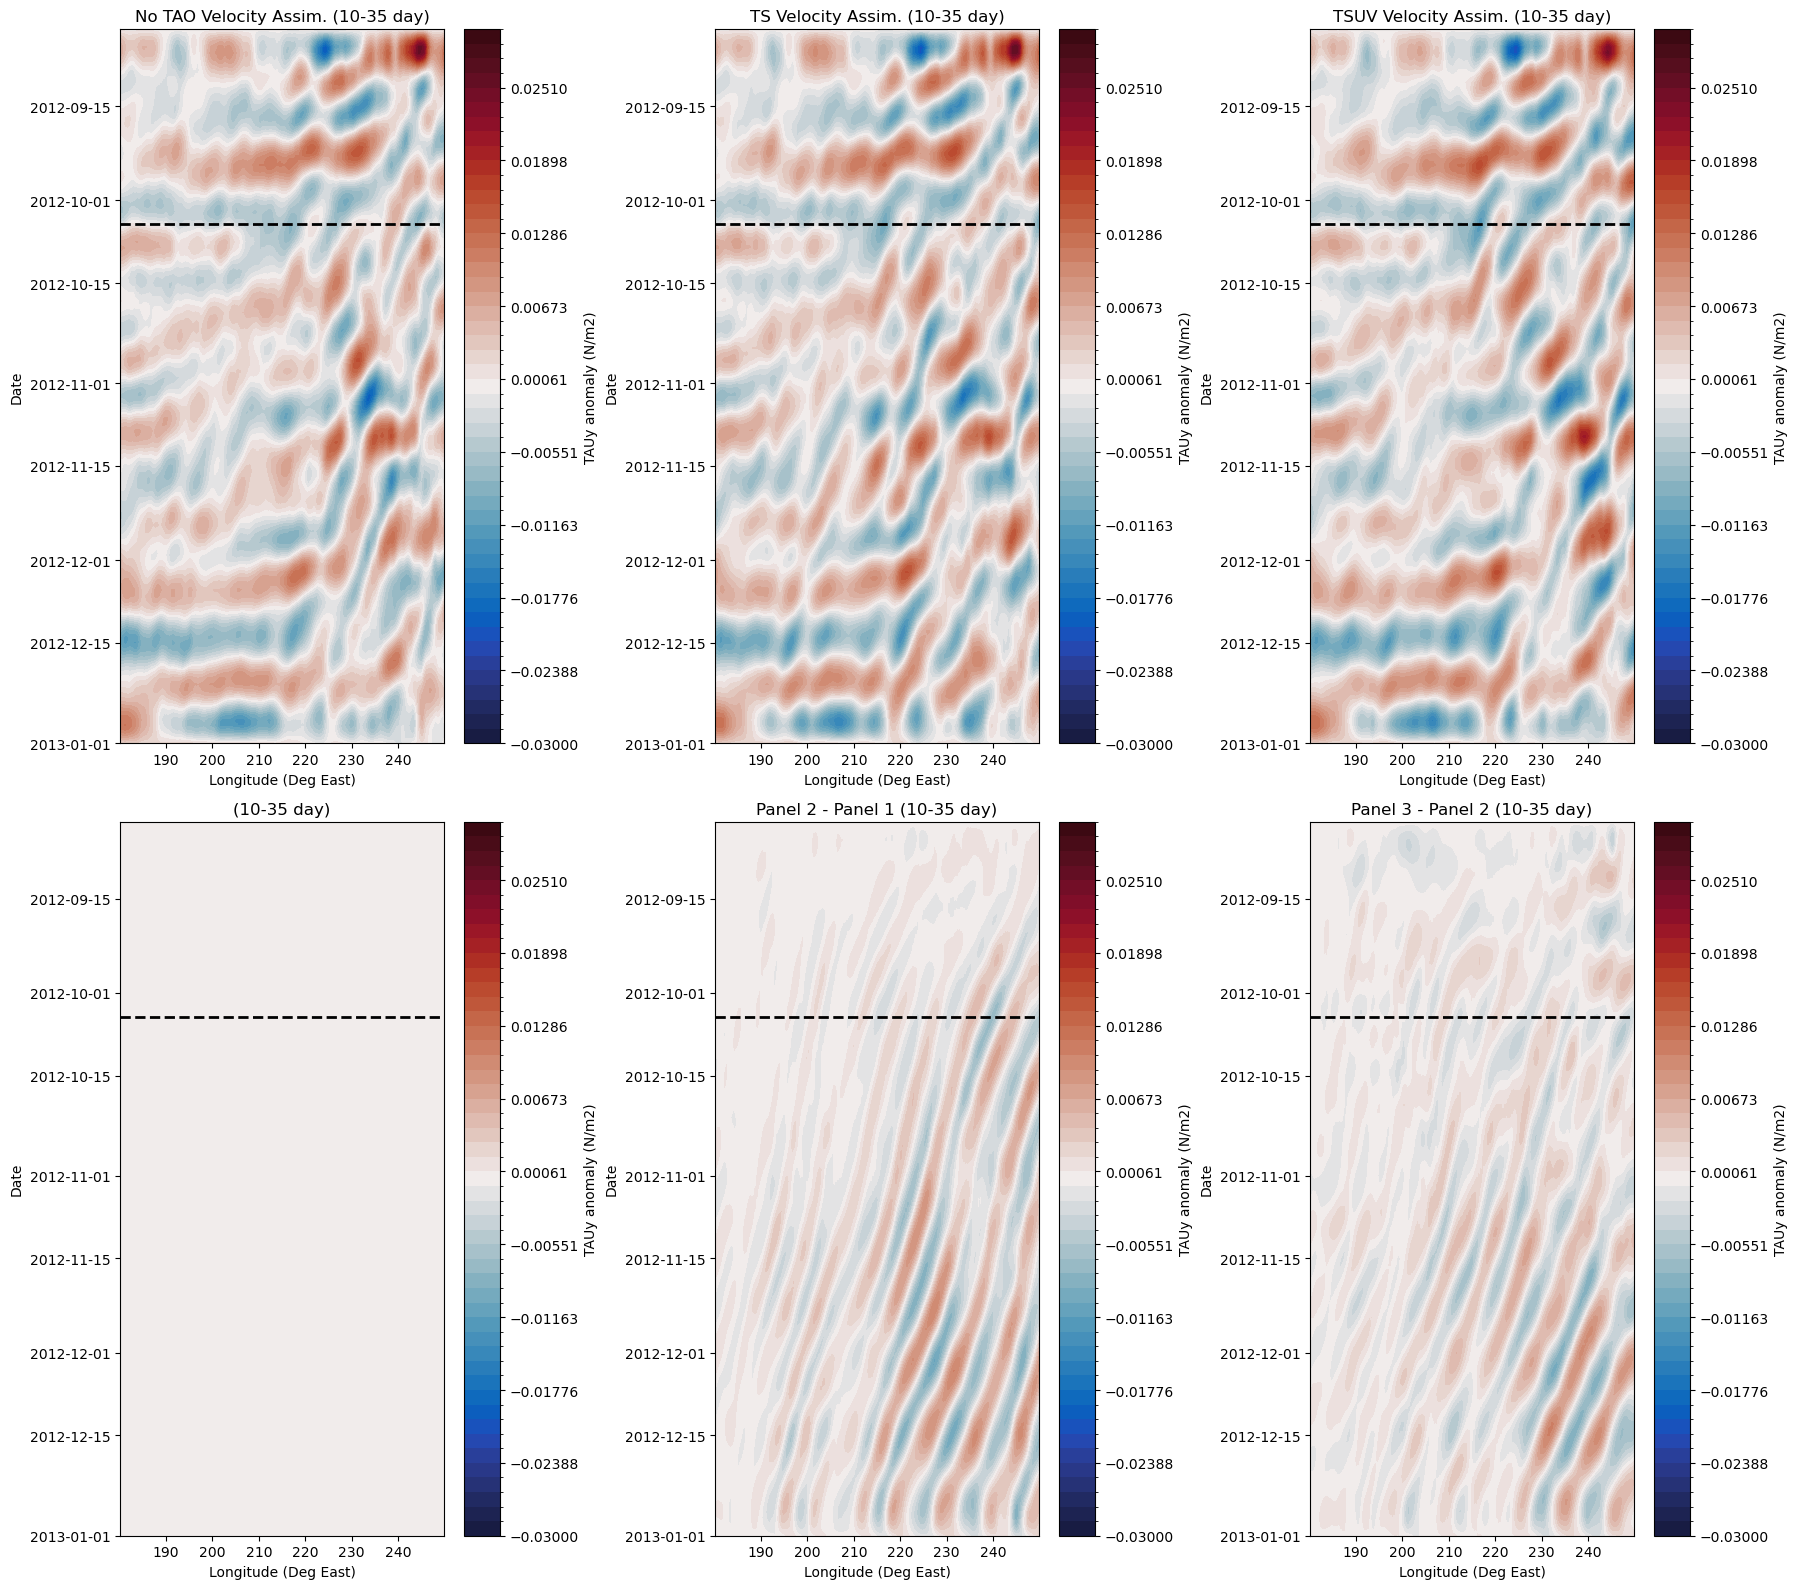

In [27]:
fs = 1/86400 # sampling rate is 1 day (86400 seconds per day)
lowF = (1/35)*fs #  (1 cycle /35 days) * (1 day/86400 second)
highF = (1/10)*fs #  (1 cycle /35 days) * (1 day/86400 second)
cutoff = np.array(highF)
order = 4
sos = signal.butter(order, [lowF, highF], 'bandpass', fs=fs, output='sos')

taux_filt = signal.sosfiltfilt(sos, taux, axis=0)
taux_filt_vel = signal.sosfiltfilt(sos, taux_vel, axis=0)
taux_filt_noTAO = signal.sosfiltfilt(sos, taux_noTAO, axis=0)

taux_filt = xr.DataArray(
    taux_filt,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_vel = xr.DataArray(
    taux_filt_vel,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

taux_filt_noTAO = xr.DataArray(
    taux_filt_noTAO,
    dims=('time', 'XC'),
    coords={'time': TAUX.time, 'XC': TAUX.XC},
    name='Z20'
)

fig, ax = plt.subplots(figsize=(18,16), ncols=3,nrows=2)

vmin = -0.03
vmax = 0.03
levels = np.linspace(vmin,vmax,50)
taux_filt_noTAO.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[0,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,0].set_xlabel('Longitude (Deg East)')
ax[0,0].set_ylabel('Date')
ax[0,0].set_title('Iteration 0 (10-35 day)')
ax[0,0].invert_yaxis()

taux_filt.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[0,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,1].set_xlabel('Longitude (Deg East)')
ax[0,1].set_ylabel('Date')
ax[0,1].set_title('Assimilation + TAO T,S (10-35 day)')
ax[0,1].invert_yaxis()

taux_filt_vel.plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[0,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[0,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[0,2].set_xlabel('Longitude (Deg East)')
ax[0,2].set_ylabel('Date')
ax[0,2].set_title('Assimilation + TAO TSUV (10-35 day)')
ax[0,2].invert_yaxis()

(taux_filt_noTAO - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,0],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[1,0].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,0].set_xlabel('Longitude (Deg East)')
ax[1,0].set_ylabel('Date')
ax[1,0].set_title('(10-35 day)')
ax[1,0].invert_yaxis()

(taux_filt - taux_filt_noTAO).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,1],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[1,1].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,1].set_xlabel('Longitude (Deg East)')
ax[1,1].set_ylabel('Date')
ax[1,1].set_title('Panel 2 - Panel 1 (10-35 day)')
ax[1,1].invert_yaxis()

(taux_filt_vel - taux_filt).plot.contourf(levels=levels,vmin=vmin,vmax=vmax,ax=ax[1,2],x='XC',cmap=cmo.balance,cbar_kwargs={'label':'TAUy anomaly (N/m2)'})
ax[1,2].axhline(y=np.datetime64('2012-10-05'),color='k',linestyle='--',linewidth=2)
ax[1,2].set_xlabel('Longitude (Deg East)')
ax[1,2].set_ylabel('Date')
ax[1,2].set_title('Panel 3 - Panel 2 (10-35 day)')
ax[1,2].invert_yaxis()

plt.tight_layout()
image_str = 'hovmoller_tauy_bandpass.png'
plt.savefig(folder_name+image_str,format='png')


In [28]:
cluster.close()
client.shutdown()
client.close()